# Predcition of Hospital Admission Related to Upper Respiratory Tract Infection, Cough, Cough Cold, and Sore Throat (combined)

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to upper respiratory tract infection (urti_combined), cough, cough cold, and sore throat combinied together.

In [104]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OneHotEncoder
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [105]:
# def create_lineplot(data, var, title, legend_title, ax1):
def create_lineplot(data, var, title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    # a.Freq = a.Freq*1000
    a = a[a.Freq > 5]
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Count')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
#     ax1.legend(title=legend_title)
    # ax1.grid()
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2020-04", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-04", color='black', ls='--', lw=1.5)

In [106]:
# function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [107]:
def round_five_mul(x, base=5):
    return base * round(x/base)

In [108]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'urti_combined_date_'+str(i), 'urti_combined_ab_date_'+str(i), 'urti_combined_ab_type_'+str(i),
                   'incdt_urti_combined_date_'+str(i), 'admitted_urti_combined_date_'+str(i), 'sgss_gp_cov_urti_combined_date_'+str(i)]]
    
    #drop rows with no urti_combined reord
    datum = datum[datum['urti_combined_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with urti_combined_i
    datum = datum[datum['sgss_gp_cov_urti_combined_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'urti_combined_date_'+str(i): 'urti_combined_date', 'urti_combined_ab_date_'+str(i): 'urti_combined_ab_date', 
                           'urti_combined_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_urti_combined_date_'+str(i): 'incdt_urti_combined_date', 'incdt_urti_combined_type_'+str(i): 'incdt_urti_combined_type',
                           'admitted_urti_combined_date_'+str(i): 'admitted_urti_combined_date',
                           'sgss_gp_cov_urti_combined_date_'+str(i): 'sgss_gp_cov_urti_combined_date'},
                inplace=True)
    
    return datum

In [109]:
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    # data_req = data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit',
    #              'event_urti_combined_admitted', 'duration_urti_combined_admitted']]
    data_req = data[vars+vars_countinuous+vars_output]

    # encoding categorical data for CPH
    # data_enc = data_req[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit']].reset_index()
    data_enc = data_req[vars+vars_countinuous].reset_index()
    # data_enc

    # creating instance of one-hot-encoder
    enc = OneHotEncoder()
    results = enc.fit_transform(data_enc)
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req, data_req_enc

In [110]:
def make_summary_table(infection, infection_type, data):
    #summary table
    summary_table = data.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = data.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = data.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'
    # summary_table

    # save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [111]:
def make_summary_table_hosped(infection, infection_type, data):
    #keep hospitalised cses (events=1)
    data_hosped = data[data['event_'+infection+'_admitted'] == 1]

    # encoding categorical hosped data
    data_hosped = data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit']].reset_index()
    # data_hosped

    # creating instance of one-hot-encoder
    enc = OneHotEncoder()
    results = enc.fit_transform(data_hosped)
    data_hosped_enc = pd.DataFrame(enc.fit_transform(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']]).toarray())
    data_hosped_enc.columns = enc.get_feature_names(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season']].columns)
    data_hosped_enc = data_hosped[['antibacterial_brit']].join(data_hosped_enc)

    # data_hosped_enc#.head()
    #summary table for hosped cases
    summary_table_hosped = data_hosped_enc.sum(axis=0).reset_index()
    summary_table_hosped.columns = ['variable', 'count']
    summary_table_hosped['mean'] = data_hosped_enc.mean(axis=0).reset_index()[0]
    #round count to make last digit either 0 or 5
    summary_table_hosped['count'] = round_five_mul(summary_table_hosped['count'], base=5)
    summary_table_hosped['std'] = data_hosped_enc.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table_hosped.loc[(summary_table_hosped['count'] <= 5), 'count'] = 'SM'
    # summary_table_hosped

    # save table
    summary_table_hosped.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'_hosped.csv', index=False)

In [112]:
def cox_model_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    return cph, data_train, data_test

In [113]:
def betas_sumbetas_calculate(cph, directory, betas_name, data_infection_enc, data_infection, sum_betas_name):
    # cleaning up covariates to make them compatible with the encoded data
    covariates = cph.params_.reset_index()#.hazard_ratios_
    covariates.covariate = covariates.covariate.str.replace("[","")
    covariates.covariate = covariates.covariate.str.replace("]","")
    covariates.covariate = covariates.covariate.str.replace("T.","_")
    # covariates.shape

    # save coefficients
    covariates.to_csv(directory+betas_name, index=False)

    # transpose and sort covariates and coefficients
    covariatesT = covariates.T
    # covariatesT.covariate = covariates
    header = covariatesT.iloc[0]
    covariatesT = covariatesT[1:]
    covariatesT.columns = header
    covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data
    # covariatesT.shape

    # further cleaning up covariates to make them compatible with the encoded data
    mylist = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
    mylist = [value.replace("'", "") for value in mylist] #removes double quotation mark 

    #match mylist (covariates of cox model) with encoded data
    data = data_infection_enc[data_infection_enc.columns.intersection(mylist)] 
    data = data.sort_index(axis = 1) #sort 
    # data.shape

    # multiply betas and encoded data
    betas = data.multiply(np.array(covariatesT), axis='columns')
    # betas

    # sum up betas of each row to calculate sum of betas 
    sum_betas = betas.sum(axis=1)
    # sum_betas
#######################################################
    # predict cumulative hazard values at day 30 and match them with sum of betas
    sum_betas_hazard = cph.predict_cumulative_hazard(data_infection).loc[[30]].T.reset_index(drop=True)
    sum_betas_hazard['sum_betas'] = sum_betas
    # sum_betas_hazard

    #drop rows with predicted risks greater than 99th percentile of all risks
    sum_betas_hazard = sum_betas_hazard[sum_betas_hazard[30] <= sum_betas_hazard[30].quantile(0.99)]  
    # return sum_betas_hazard

    # sort values of sum of betas
    sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])
    # sum_betas_hazard

    # binning sum of betas into 100 bins
    sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas
    # sum_betas_hazard

    #calculate mean of cumulative hazar at day 30 by groupby 
    sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()
    # sum_betas_hazard_groupby

    #calculate interpolation of missing mean values 
    sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

    # separate upper and lower boundries of bins
    sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
    sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))
    # sum_betas_hazard_groupby.head()

    # select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
    sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean_interpolate']]

    # save relevant columns of sum_betas
    sum_betas.to_csv(directory+sum_betas_name, index=False)

In [114]:
def cph_roc_curve(cph, event_col_name, data_train, data_test, directory, roc_name):
    # analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_train_cumulative_hazard = cph.predict_cumulative_hazard(data_train)
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.loc[[30]].T
    cph_train_cumulative_hazard[event_col_name] = data_train[event_col_name]
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
    # cph_train_cumulative_hazard

    # analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_test_cumulative_hazard = cph.predict_cumulative_hazard(data_test)
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.loc[[30]].T
    cph_test_cumulative_hazard[event_col_name] = data_test[event_col_name]
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
    # cph_test_cumulative_hazard

    # plot roc curves
    r_fpr1, r_tpr1, _ = roc_curve(cph_train_cumulative_hazard[event_col_name], cph_train_cumulative_hazard.cumulative_hazard)
    r_fpr2, r_tpr2, _ = roc_curve(cph_test_cumulative_hazard[event_col_name], cph_test_cumulative_hazard.cumulative_hazard)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='Cox with development data')
    line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='Cox with validation data')

    squares = [0,1.01]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=14)
    # plt.title('', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    # plt.tight_layout()
    plt.savefig(directory+'/'+roc_name, bbox_inches='tight')
    plt.show()

In [115]:
def cph_calibration(cph, data_train, event_name, data_test, directory, calib_train_name, calib_test_name):
    #predict cumulative hazard in day 30
    prob_pred_true_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_true_train.columns = ['pred']
    # prob_pred_true_train

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)
    # prob_pred_true_train

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_train = pd.merge(prob_pred_true_train, data_train[event_name], left_index=True, right_index=True)
    # prob_pred_true_train

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']
    # prob_pred_true_train_groupby_bin

    #calculate proportion of events in each bin
    prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin['event_sum']/prob_pred_true_train_groupby_bin['event_count']
    # prob_pred_true_train_groupby_bin
############
    #predict cumulative hazard in day 30
    prob_pred_true_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T #[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'gp_count']]).loc[[30]].T#.reset_index(drop=True)
    prob_pred_true_test.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_test = pd.merge(prob_pred_true_test, data_test[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin['event_sum']/prob_pred_true_test_groupby_bin['event_count']
    # prob_pred_true_test_groupby_bin
###################
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_train_name, bbox_inches='tight')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_test_name, bbox_inches='tight')
    plt.show()

In [116]:
def cph_output(cph, infection, infection_type, data_train, data_test, event_name, duration_name, directory):
    # calculate concordance index, AUROC, and Brier score of cph model
    concord_index_train = concordance_index(data_train[duration_name], -cph.predict_partial_hazard(data_train), data_train[event_name])
    concord_index_test = concordance_index(data_test[duration_name], -cph.predict_partial_hazard(data_test), data_test[event_name])
    
    # save model outputs
    a = open(directory+'cph_'+infection+'_'+infection_type+'_output.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (concord_index_train), 
                '\nConcordance index for '+infection+'_'+infection_type+' with validation data: %.4f' % (concord_index_test)])

In [117]:
def cox_model_abs_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + urti_combined_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    return cph, data_train, data_test

In [118]:
def cox_model_ab_type_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + ab_type_cat"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    return cph, data_train, data_test

In [119]:
def cox_model_strat_sex_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + urti_combined_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    return cph, data_train, data_test

In [120]:
def cox_model_strat_age_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + urti_combined_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    return cph, data_train, data_test

## 1- data preparation

In [121]:
#function to process infection data combined urti
def proc_infec_data_combined_urti(data, infection):
    #rename variables with i
    for i in range(1,21):
        data.rename(columns={infection+'_date_'+str(i): 'urti_combined_date_'+str(i), infection+'_ab_date_'+str(i): 'urti_combined_ab_date_'+str(i),
                            infection+'_ab_type_'+str(i): 'urti_combined_ab_type_'+str(i), 'incdt_'+infection+'_date_'+str(i): 'incdt_urti_combined_date_'+str(i), 
                            'incdt_'+infection+'_type_'+str(i): 'incdt_urti_combined_type_'+str(i), 'admitted_'+infection+'_date_'+str(i): 'admitted_urti_combined_date_'+str(i),
                            'gp_covid_date_'+infection+'_'+str(i): 'gp_covid_date_combined_urti_'+str(i), 'sgss_gp_cov_'+infection+'_date_'+str(i): 'sgss_gp_cov_urti_combined_date_'+str(i),
                            'sgss_pos_covid_date_'+infection+'_'+str(i): 'sgss_pos_covid_date_urti_combined_'+str(i), infection+'_ab_count_'+str(i): 'urti_combined_ab_count_'+str(i)},
                    inplace=True)
    
    return data

In [122]:
#read data
data_urti = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_urti.csv.gz')
data_cough = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_cough.csv.gz')
data_cough_cold = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_cough_cold.csv.gz')
data_throat = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_throat.csv.gz')

In [123]:
#convert data into combined_urti and concat them
data_urti_converted = proc_infec_data_combined_urti(data_urti, 'urti')
data_cough_converted = proc_infec_data_combined_urti(data_cough, 'cough')
data_cough_cold_converted = proc_infec_data_combined_urti(data_cough_cold, 'cough_cold')
data_throat_converted = proc_infec_data_combined_urti(data_throat, 'throat')

frames = [data_urti_converted, data_cough_converted, data_cough_cold_converted, data_throat_converted]
data = pd.concat(frames)

data.shape

(800000, 224)

### 1-2- additional variables
Calculating Charlson Comorbidity Index based on https://www.nature.com/articles/4500889.pdf?origin=ppub

In [125]:
data['CCI'] = np.nan
col0 = data.columns.get_loc('CCI')

col1 = data.columns.get_loc('cancer_comor')
col2 = data.columns.get_loc('cardiovascular_comor')
col3 = data.columns.get_loc('chronic_obstructive_pulmonary_comor') ##
col4 = data.columns.get_loc('heart_failure_comor') ##
col5 = data.columns.get_loc('connective_tissue_comor')
col6 = data.columns.get_loc('dementia_comor')
col7 = data.columns.get_loc('diabetes_comor')
col8 = data.columns.get_loc('diabetes_complications_comor')
col9 = data.columns.get_loc('hemiplegia_comor')
col10 = data.columns.get_loc('hiv_comor')
col11 = data.columns.get_loc('metastatic_cancer_comor')
col12 = data.columns.get_loc('mild_liver_comor')
col13 = data.columns.get_loc('mod_severe_liver_comor')
col14 = data.columns.get_loc('mod_severe_renal_comor')
col15 = data.columns.get_loc('mi_comor')
col16 = data.columns.get_loc('peptic_ulcer_comor')
col17 = data.columns.get_loc('peripheral_vascular_comor')


for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, col15] == 1: # mi_comor
        n=n+1
    if data.iat[idx, col2] == 1: # cardiovascular_comor
        n=n+1 
    if data.iat[idx, col17] == 1: # peripheral_vascular_comor
        n=n+1 
    if data.iat[idx, col3] == 1: # chronic_obstructive_pulmonary_comor
        n=n+1
    if data.iat[idx, col7] == 1: # diabetes_comor
        n=n+1
    if data.iat[idx, col6] == 1: # dementia_comor
        n=n+1
    if data.iat[idx, col16] == 1: # peptic_ulcer_comor
        n=n+1
    if data.iat[idx, col5] == 1: # connective_tissue_comor
        n=n+1
    if data.iat[idx, col12] == 1: # mild_liver_comor
        n=n+1
    if data.iat[idx, col9] == 1: # hemiplegia_comor
        n=n+2
    if data.iat[idx, col14] == 1: # mod_severe_renal_comor
        n=n+2
    if data.iat[idx, col8] == 1: # diabetes_complications_comor
        n=n+2
    if data.iat[idx, col1] == 1: # cancer_comor
        n=n+2
    if data.iat[idx, col13] == 1: # mod_severe_liver_comor
        n=n+3
    if data.iat[idx, col11] == 1: # metastatic_cancer_comor
        n=n+6
    if data.iat[idx, col10] == 1: # hiv_comor
        n=n+6
    
    data.iat[idx, col0]=n

data.CCI.value_counts()

1.0     148322
0.0     147931
2.0     131913
3.0      99352
4.0      59724
6.0      49159
7.0      40080
5.0      33615
8.0      31826
9.0      23276
10.0     13266
11.0      7514
12.0      5414
13.0      3397
14.0      2220
15.0      1464
16.0       770
17.0       427
18.0       190
19.0        83
20.0        44
21.0         8
22.0         4
24.0         1
Name: CCI, dtype: int64

## 2- data preparation
This includes data type conversion and exclusion of cases that are not considered in the infection-related hospital admission, i.e. those who were diagnosed with Covid19 three months (=90 days) before and one month (=30 days) after hospital admission.

### 2-1- gathering data

In [126]:
#read 12 urti_combineds and concatenate them 
data_urti_combined_1 = proc_infec_data(data,1)
data_urti_combined_2 = proc_infec_data(data,2)
data_urti_combined_3 = proc_infec_data(data,3)
data_urti_combined_4 = proc_infec_data(data,4)
data_urti_combined_5 = proc_infec_data(data,5)
data_urti_combined_6 = proc_infec_data(data,6)
data_urti_combined_7 = proc_infec_data(data,7)
data_urti_combined_8 = proc_infec_data(data,8)
data_urti_combined_9 = proc_infec_data(data,9)
data_urti_combined_10 = proc_infec_data(data,10)
data_urti_combined_11 = proc_infec_data(data,11)
data_urti_combined_12 = proc_infec_data(data,12)
data_urti_combined_13 = proc_infec_data(data,13)
data_urti_combined_14 = proc_infec_data(data,14)
data_urti_combined_15 = proc_infec_data(data,15)
data_urti_combined_16 = proc_infec_data(data,16)
data_urti_combined_17 = proc_infec_data(data,17)
data_urti_combined_18 = proc_infec_data(data,18)
data_urti_combined_19 = proc_infec_data(data,19)
data_urti_combined_20 = proc_infec_data(data,20)

data_urti_combined = pd.concat([data_urti_combined_1, data_urti_combined_2, data_urti_combined_3, data_urti_combined_4, data_urti_combined_5, data_urti_combined_6, data_urti_combined_7, data_urti_combined_8, data_urti_combined_9, data_urti_combined_10, data_urti_combined_11, data_urti_combined_12, data_urti_combined_13, data_urti_combined_14, data_urti_combined_15, data_urti_combined_16, data_urti_combined_17, data_urti_combined_18, data_urti_combined_19, data_urti_combined_20])
data_urti_combined.reset_index(inplace=True, drop=True)
data_urti_combined.shape

(1440213, 20)

### 2-2- add season, event, and duration variables
#### season

In [127]:
# convert data types
data_urti_combined['urti_combined_date'] = data_urti_combined['urti_combined_date'].astype('datetime64[ns]')
data_urti_combined['admitted_urti_combined_date'] = data_urti_combined['admitted_urti_combined_date'].astype('datetime64[ns]')
data_urti_combined.died_date = data_urti_combined.died_date.astype('datetime64[ns]')
data_urti_combined.deregistered_date = data_urti_combined.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_urti_combined['date'] = data_urti_combined['urti_combined_date'] #gp_cons_urti_combined
data_urti_combined['date'] = data_urti_combined['date'].dt.strftime('%Y-%m')
print(f'min date: {data_urti_combined.date.min()}')
print(f'max date: {data_urti_combined.date.max()}')
print(f'length of data_urti_combined: {len(data_urti_combined)}')

min date: 2019-01
max date: 2022-11
length of data_urti_combined: 1440213


In [128]:
#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')
# today_date_y_m

#drop any records of data_urti_combined with today's date in year and month
data_urti_combined = data_urti_combined[data_urti_combined['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_urti_combined = data_urti_combined[data_urti_combined['date'] != last_1_month_date_y_m]
data_urti_combined = data_urti_combined[data_urti_combined['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of urti_combined records
data_urti_combined['season'] = np.nan
data_urti_combined['date_month'] = pd.DatetimeIndex(data_urti_combined['date']).month

conditions = [
    (data_urti_combined['date_month'] >= 3) & (data_urti_combined['date_month'] <= 5),
    (data_urti_combined['date_month'] >= 6) & (data_urti_combined['date_month'] <= 8),
    (data_urti_combined['date_month'] >= 9) & (data_urti_combined['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_urti_combined['season'] = np.select(conditions, choices, default='winter')

print(data_urti_combined['season'].value_counts())
print(f'\nmin date: {data_urti_combined.date.min()}')
print(f'max date: {data_urti_combined.date.max()}')
print(f'length: {len(data_urti_combined)}')

spring    374668
summer    373820
winter    335149
autumn    277354
Name: season, dtype: int64

min date: 2019-01
max date: 2022-08
length: 1360991


In [129]:
# data_urti_combined = data_urti_combined[data_urti_combined['date'] <= '2019-12']
# data_urti_combined = data_urti_combined[(data_urti_combined['date'] >= '2020-03') & (data_urti_combined['date']<= '2021-03')]
# data_urti_combined = data_urti_combined[data_urti_combined['date'] >= '2021-04']
# print(f'min date: {data_urti_combined.date.min()}')
# print(f'max date: {data_urti_combined.date.max()}')

#### event and duration

In [130]:
#scenario 1
#not hosped (nothing happened)
#data_urti_combined = data_urti_combined[data_urti_combined['admitted_urti_combined_date'].notnull()]
data_urti_combined.loc[data_urti_combined['admitted_urti_combined_date'].isnull(), 'event_urti_combined_admitted'] = 0
data_urti_combined['event_urti_combined_admitted'].value_counts()

0.0    952631
Name: event_urti_combined_admitted, dtype: int64

In [131]:
#scenario 2 
# become a case (uncensoring)
#calculating days between infection gp consultation and hosp
# data_urti_combined['delta_urti_combined_admitted'] = (data_urti_combined['admitted_urti_combined_date'] - data_urti_combined['urti_combined_date']).dt.days
data_urti_combined['delta_urti_combined_admitted'] = (data_urti_combined['admitted_urti_combined_date'] - data_urti_combined['urti_combined_date']).dt.days #gp_cons_urti_combined
data_urti_combined.loc[((data_urti_combined['delta_urti_combined_admitted'] >= 0) & (data_urti_combined['delta_urti_combined_admitted'] <= 30)), 'event_urti_combined_admitted'] = 1
# data_urti_combined['event_urti_combined_admitted'].value_counts()

#scenario 2
#drop whoever was admitted before urti_combined consultation, i.e. negative value for delta_urti_combined_admitted
data_urti_combined = data_urti_combined[~(data_urti_combined['delta_urti_combined_admitted'] < 0)]
data_urti_combined['delta_urti_combined_admitted'].value_counts()

16.0      336
84.0      334
93.0      332
23.0      329
24.0      329
         ... 
1406.0      2
1403.0      2
1401.0      2
1409.0      1
1412.0      1
Name: delta_urti_combined_admitted, Length: 1413, dtype: int64

In [132]:
#scenario 3
#censor died patients
data_urti_combined['delta_admitted_died'] = (data_urti_combined['died_date'] - data_urti_combined['admitted_urti_combined_date']).dt.days
data_urti_combined.loc[data_urti_combined['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
# data_urti_combined.loc[data_urti_combined['delta_admitted_died'] >= 0, 'event_urti_combined_admitted'] = 0
data_urti_combined.loc[((data_urti_combined['delta_admitted_died'] >= 0) & (data_urti_combined['delta_admitted_died'] <= 30)), 'event_urti_combined_admitted'] = 0
# data_urti_combined['event_urti_combined_admitted'].value_counts()

#scenario 3
#censor deregistered patients
data_urti_combined['delta_admitted_deregistered'] = (data_urti_combined['deregistered_date'] - data_urti_combined['admitted_urti_combined_date']).dt.days
data_urti_combined.loc[data_urti_combined['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
# data_urti_combined.loc[data_urti_combined['delta_admitted_deregistered'] >= 0, 'event_urti_combined_admitted'] = 0
data_urti_combined.loc[((data_urti_combined['delta_admitted_deregistered'] > 0) & (data_urti_combined['delta_admitted_deregistered'] <= 30)), 'event_urti_combined_admitted'] = 0
# data_urti_combined['event_urti_combined_admitted'].value_counts()

#agg scenario 3s
data_urti_combined['delta_admitted_died_deregistered'] = data_urti_combined['delta_admitted_deregistered'].combine_first(data_urti_combined['delta_admitted_died'])
data_urti_combined.loc[data_urti_combined['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN
data_urti_combined['delta_admitted_died_deregistered'].isnull().sum()#.value_counts()

1147391

In [133]:
#scenario 1
#any other patients (nothing happened)
data_urti_combined['event_urti_combined_admitted'] = data_urti_combined['event_urti_combined_admitted'].replace(np.NaN, 0)
data_urti_combined['event_urti_combined_admitted'].value_counts()

0.0    1159450
1.0       8988
Name: event_urti_combined_admitted, dtype: int64

In [134]:
#assign values for duration column
data_urti_combined['duration_urti_combined_admitted'] = data_urti_combined['delta_urti_combined_admitted'].combine_first(data_urti_combined['delta_admitted_died_deregistered'])
data_urti_combined['duration_urti_combined_admitted'] = data_urti_combined['duration_urti_combined_admitted'].replace(np.NaN, 30)
data_urti_combined.loc[(data_urti_combined['duration_urti_combined_admitted'] > 30), 'duration_urti_combined_admitted'] = 30
data_urti_combined['duration_urti_combined_admitted'].value_counts()

30.0    1159716
16.0        336
24.0        329
23.0        329
20.0        327
11.0        313
12.0        312
2.0         311
17.0        305
18.0        299
22.0        294
9.0         294
0.0         291
7.0         289
29.0        287
28.0        286
26.0        286
1.0         285
21.0        282
4.0         280
15.0        280
5.0         278
6.0         275
25.0        273
8.0         273
3.0         272
13.0        272
10.0        268
27.0        266
19.0        266
14.0        264
Name: duration_urti_combined_admitted, dtype: int64

In [135]:
# give value 1 to event_urti_combined_admitted if duration_urti_combined_admitted is greater or equal to 0 and less than 30
data_urti_combined.loc[((data_urti_combined['duration_urti_combined_admitted'] >= 0) & (data_urti_combined['duration_urti_combined_admitted'] < 30)), 'event_urti_combined_admitted'] = 1
data_urti_combined['event_urti_combined_admitted'].value_counts()

0.0    1159434
1.0       9004
Name: event_urti_combined_admitted, dtype: int64

In [136]:
#drop any rows with value 0 in duration column
data_urti_combined = data_urti_combined[~(data_urti_combined['duration_urti_combined_admitted'] == 0)]

#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_urti_combined.loc[((data_urti_combined['delta_urti_combined_admitted'] > 0) & (data_urti_combined['delta_urti_combined_admitted'] < 30)), 'event_urti_combined_admitted'] = 1

In [137]:
# data_urti_combined[data_urti_combined['duration_urti_combined_admitted']==0][['delta_urti_combined_admitted', 'urti_combined_date', 'gp_cons_urti_combined', 'admitted_urti_combined_date', 'delta_urti_combined_admitted', 'delta_admitted_died_deregistered', 'event_urti_combined_admitted', 'duration_urti_combined_admitted']]
# data_urti_combined.loc[151:200, ['event_urti_combined_admitted', 'duration_urti_combined_admitted']]
# data_urti_combined.loc[201:250, ['event_urti_combined_admitted', 'duration_urti_combined_admitted']].sort_values(by=['duration_urti_combined_admitted'])
data_urti_combined[['event_urti_combined_admitted', 'duration_urti_combined_admitted']].sort_values(by=['duration_urti_combined_admitted'])

,event_urti_combined_admitted,duration_urti_combined_admitted
701716,1.0,1.0
759707,1.0,1.0
694475,1.0,1.0
247993,1.0,1.0
203952,1.0,1.0
...,...,...
481888,0.0,30.0
481887,0.0,30.0
481885,0.0,30.0
481897,0.0,30.0


### 2-3- dealing with uninteresting and missing values

In [138]:
# prep before plot
data_urti_combined['age'][data_urti_combined['age'] < 0] = np.nan
data_urti_combined = data_urti_combined[data_urti_combined['age_cat'] != '0-4']
data_urti_combined = data_urti_combined[data_urti_combined['age_cat'] != '5-14']
# drop anybody with age less than 18
data_urti_combined = data_urti_combined[~(data_urti_combined['age'] < 18)]  
print(f'Min age: {data_urti_combined.age.min()}')

## remove died cases
#data_urti_combined.died_date.value_counts()

# assign 0 (missingness) to all bmi values less than 10
data_urti_combined['bmi'][data_urti_combined['bmi'] < 10] = 0
# replace 0s with nans
data_urti_combined['bmi'] = data_urti_combined['bmi'].replace({0:np.nan})

# remove cases with negative antibacterial_brit
data_urti_combined['antibacterial_brit'][data_urti_combined['antibacterial_brit'] < 0] = np.nan

Min age: 18


In [139]:
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_urti_combined = data_urti_combined.replace({"sex": dict_sex})
# data_bmi = data_bmi.replace({"sex": dict_sex})
data_urti_combined = data_urti_combined.replace({"smoking_status": dict_smoking})

In [140]:
if ('region' in data_urti_combined.columns) and (data_urti_combined['region'].isnull().sum() > 0):
    # drop region value missing
    # data_urti_combined['region_imp'] = data_urti_combined['region']
    print(f'Cound of missing values in variable region before dropping rows with possible missing values: {data_urti_combined.region.isnull().sum()}')
    data_urti_combined = data_urti_combined[data_urti_combined['region'].notna()]

print(f'Cound of missing values in variable region: {data_urti_combined.region.isnull().sum()}')
print(f'Count of categories of variable region: \n{data_urti_combined.region.value_counts()}')

Cound of missing values in variable region: 0
Count of categories of variable region: 
London                      141917
Yorkshire and The Humber     71366
South East                   71101
East                         70834
East Midlands                70807
North East                   70717
South West                   70707
West Midlands                70698
North West                   70131
Name: region, dtype: int64


In [141]:
if ('antibacterial_brit' in data_urti_combined.columns) and (data_urti_combined['antibacterial_brit'].isnull().sum() > 0):
    print(f'Cound of missing values in variable antibacterial_brit before changing NANs to zeros: {data_urti_combined.antibacterial_brit.isnull().sum()}')
    print(f'Mean of antibacterial_brit values before changing NAN to zeros: {data_urti_combined.antibacterial_brit.mean():.3f}')
    data_urti_combined['antibacterial_brit'] = data_urti_combined['antibacterial_brit'].fillna(0)
    # data_urti_combined['antibacterial_brit'] = data_urti_combined['antibacterial_brit'].replace({'0':np.nan, 0:np.nan})

print(f'\nCound of missing values in variable antibacterial_brit after changing NANs to zeros: {data_urti_combined.antibacterial_brit.isnull().sum()}')
print(f'Mean of antibacterial_brit values after changing NANs to zeros: {data_urti_combined.antibacterial_brit.mean():.3f}')

Cound of missing values in variable antibacterial_brit before changing NANs to zeros: 10
Mean of antibacterial_brit values before changing NAN to zeros: 1.248

Cound of missing values in variable antibacterial_brit after changing NANs to zeros: 0
Mean of antibacterial_brit values after changing NANs to zeros: 1.248


In [142]:
if ('ethnicity' in data_urti_combined.columns) and (data_urti_combined['ethnicity'].isnull().sum() > 0):
    print(f'Count of missing values in variable ethnicity before changing them to Unknown category: {data_urti_combined.ethnicity.isnull().sum()}')
    print(f'Count of categories of variable ethnicity before changing them to Unknown category: \n{data_urti_combined.ethnicity.value_counts()}')
    # data_urti_combined['ethnicity'] = data_urti_combined['ethnicity'].astype(str)
    data_urti_combined['ethnicity'] = data_urti_combined['ethnicity'].fillna(0)

print(f'\nCound of missing values in variable ethnicity after changing NANs to Unknown category: {data_urti_combined.ethnicity.isnull().sum()}')
print(f'Count of categories of variable ethnicity after changing NANs to Unknown category: \n{data_urti_combined.ethnicity.value_counts()}')

Count of missing values in variable ethnicity before changing them to Unknown category: 176759
Count of categories of variable ethnicity before changing them to Unknown category: 
1.0    425479
5.0     53610
3.0     52430
Name: ethnicity, dtype: int64

Cound of missing values in variable ethnicity after changing NANs to Unknown category: 0
Count of categories of variable ethnicity after changing NANs to Unknown category: 
1.0    425479
0.0    176759
5.0     53610
3.0     52430
Name: ethnicity, dtype: int64


In [143]:
if ('smoking_status' in data_urti_combined.columns) and (data_urti_combined['smoking_status'].isnull().sum() > 0):
    print(f'Count of missing values in variable smoking_status before changing them to Unknown category: {data_urti_combined.smoking_status.isnull().sum()}')
    print(f'Count of categories of variable smoking_status before changing them to Unknown category: \n{data_urti_combined.smoking_status.value_counts()}')
    # data_urti_combined['smoking_status'] = data_urti_combined['smoking_status'].astype(str)
    data_urti_combined['smoking_status'] = data_urti_combined['smoking_status'].fillna(0)

print(f'\nCound of missing values in variable smoking_status after changing NANs to Unknown category: {data_urti_combined.smoking_status.isnull().sum()}')
print(f'Count of categories of variable smoking_status after changing NANs to Unknown category: \n{data_urti_combined.smoking_status.value_counts()}')

Count of missing values in variable smoking_status before changing them to Unknown category: 293690
Count of categories of variable smoking_status before changing them to Unknown category: 
1.0    276893
3.0     91711
2.0     45984
Name: smoking_status, dtype: int64

Cound of missing values in variable smoking_status after changing NANs to Unknown category: 0
Count of categories of variable smoking_status after changing NANs to Unknown category: 
0.0    293690
1.0    276893
3.0     91711
2.0     45984
Name: smoking_status, dtype: int64


In [144]:
if ('imd' in data_urti_combined.columns) and (data_urti_combined['imd'].isnull().sum() > 0):
    print(f'Count of missing values in variable imd before changing them to Unknown category: {data_urti_combined.imd.isnull().sum()}')
    print(f'Count of categories of variable imd before changing them to Unknown category: \n{data_urti_combined.imd.value_counts()}')
    # data_urti_combined['imd'] = data_urti_combined['imd'].astype(str)
    data_urti_combined['imd'] = data_urti_combined['imd'].fillna(0)

print(f'\nCound of missing values in variable imd after changing NANs to Unknown category: {data_urti_combined.imd.isnull().sum()}')
print(f'Count of categories of variable imd after changing NANs to Unknown category: \n{data_urti_combined.imd.value_counts()}')


Cound of missing values in variable imd after changing NANs to Unknown category: 0
Count of categories of variable imd after changing NANs to Unknown category: 
4    134961
3    134785
5    134518
2    134464
1    133857
0     35693
Name: imd, dtype: int64


In [145]:
data_urti_combined['bmi_cat'] = 5
col_bmi_cat = data_urti_combined.columns.get_loc('bmi_cat')

col_sex = data_urti_combined.columns.get_loc('sex')
col_age = data_urti_combined.columns.get_loc('age')
col_bmi = data_urti_combined.columns.get_loc('bmi')

for idx, x in enumerate(data_urti_combined['bmi_cat']):
    if data_urti_combined.iat[idx, col_bmi] >= 30:
        data_urti_combined.iat[idx, col_bmi_cat] = 1 #'Obese'
    if (data_urti_combined.iat[idx, col_bmi] >= 25) and (data_urti_combined.iat[idx, col_bmi] < 30):
        data_urti_combined.iat[idx, col_bmi_cat] = 2 #'Overweight'
    if (data_urti_combined.iat[idx, col_bmi] >= 18.5) and (data_urti_combined.iat[idx, col_bmi] < 25):
        data_urti_combined.iat[idx, col_bmi_cat] = 3 #'Healthy weight'
    if data_urti_combined.iat[idx, col_bmi] < 18.5:
        data_urti_combined.iat[idx, col_bmi_cat] = 4 #'Underweight'

data_urti_combined['bmi_cat'].value_counts()

1    367125
5    180025
2     79911
3     58236
4     22981
Name: bmi_cat, dtype: int64

In [146]:
if ('bmi_cat' in data_urti_combined.columns) and (data_urti_combined['bmi_cat'].isnull().sum() > 0):
    print(f'Count of missing values in variable bmi_cat before changing them to Unknown category: {data_urti_combined.bmi_cat.isnull().sum()}')
    print(f'Count of categories of variable bmi_cat before changing them to Unknown category: \n{data_urti_combined.bmi_cat.value_counts()}')
    # data_urti_combined['bmi_cat'] = data_urti_combined['bmi_cat'].astype(str)
    data_urti_combined['bmi_cat'] = data_urti_combined['bmi_cat'].fillna(0)

print(f'\nCound of missing values in variable bmi_cat after changing NANs to Unknown category: {data_urti_combined.bmi_cat.isnull().sum()}')
print(f'Count of categories of variable bmi_cat after changing NANs to Unknown category: \n{data_urti_combined.bmi_cat.value_counts()}')


Cound of missing values in variable bmi_cat after changing NANs to Unknown category: 0
Count of categories of variable bmi_cat after changing NANs to Unknown category: 
1    367125
5    180025
2     79911
3     58236
4     22981
Name: bmi_cat, dtype: int64


In [147]:
#add variable ab_type_cat
#find ab types
ab_series = pd.value_counts(data_urti_combined.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_urti_combined['ab_type_cat'] = np.where(data_urti_combined['ab_type'].isin(ab_series[mask].index),'other',data_urti_combined['ab_type'])

#assign no to non ab users
data_urti_combined.loc[data_urti_combined['urti_combined_ab_date'].isnull(), 'ab_type_cat'] = 'no'

#fill nas with 0 and then assign other to 0s
data_urti_combined['ab_type_cat'] = data_urti_combined['ab_type_cat'].fillna(0)
data_urti_combined['ab_type_cat'].value_counts()

no             637799
0               56360
other            8394
Amoxicillin      4363
Doxycycline      1362
Name: ab_type_cat, dtype: int64

### 2-4- translate values of categorical variables

In [148]:
# define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'non-white', 3.0: 'non-white', 4.0: 'non-white', 5.0: 'non-white', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

In [149]:
# reoplace values of dictionaries with existing ones
data_urti_combined = data_urti_combined.replace({"sex": dict_sex})
data_urti_combined = data_urti_combined.replace({"ethnicity": dict_ethnicity})
data_urti_combined = data_urti_combined.replace({"smoking_status": dict_smoking})
data_urti_combined = data_urti_combined.replace({"imd": dict_imd})
data_urti_combined = data_urti_combined.replace({"bmi_cat": dict_bmi})
data_urti_combined = data_urti_combined.replace({"flu_vaccine": dict_flu})
data_urti_combined = data_urti_combined.replace({"region": dict_region})
data_urti_combined = data_urti_combined.replace({"age_cat": dict_age})
data_urti_combined = data_urti_combined.replace({"ab_type_cat": dict_ab_type})
data_urti_combined['ab_type_cat'].value_counts()

no             637799
other           64754
Amoxicillin      4363
Doxycycline      1362
Name: ab_type_cat, dtype: int64

### 2-5- categorising and assigning max value for continuous variables

In [150]:
# categorising
data_urti_combined['CCI_cat'] = pd.cut(data_urti_combined['CCI'], right=False, bins=[0,1,3,5,7,10000000000], labels=['very_low', 'low', 'medium', 'high', 'very_high'])
data_urti_combined['CCI_cat'].value_counts()

low          248768
medium       141061
very_low     130670
very_high    114655
high          73124
Name: CCI_cat, dtype: int64

In [151]:
# assign max value to outliers (beyond 95 percentile)
data_urti_combined['antibacterial_brit'].clip(0, data_urti_combined['antibacterial_brit'].quantile(0.95), inplace=True)
data_urti_combined['antibacterial_brit'].max()

data_urti_combined['antibacterial_brit_cat'] = pd.cut(data_urti_combined['antibacterial_brit'], 3, labels=['low', 'medium', 'high'])
data_urti_combined['antibacterial_brit_cat'].value_counts()

low       411074
high      177070
medium    120134
Name: antibacterial_brit_cat, dtype: int64

## 3- plots

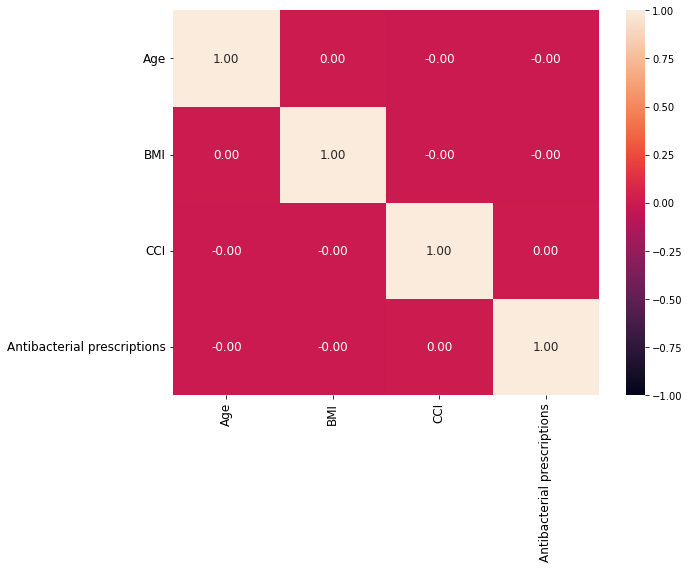

In [152]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data_urti_combined[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=12)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=12)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti_combined/corr_urti_combined.jpg')
plt.show()

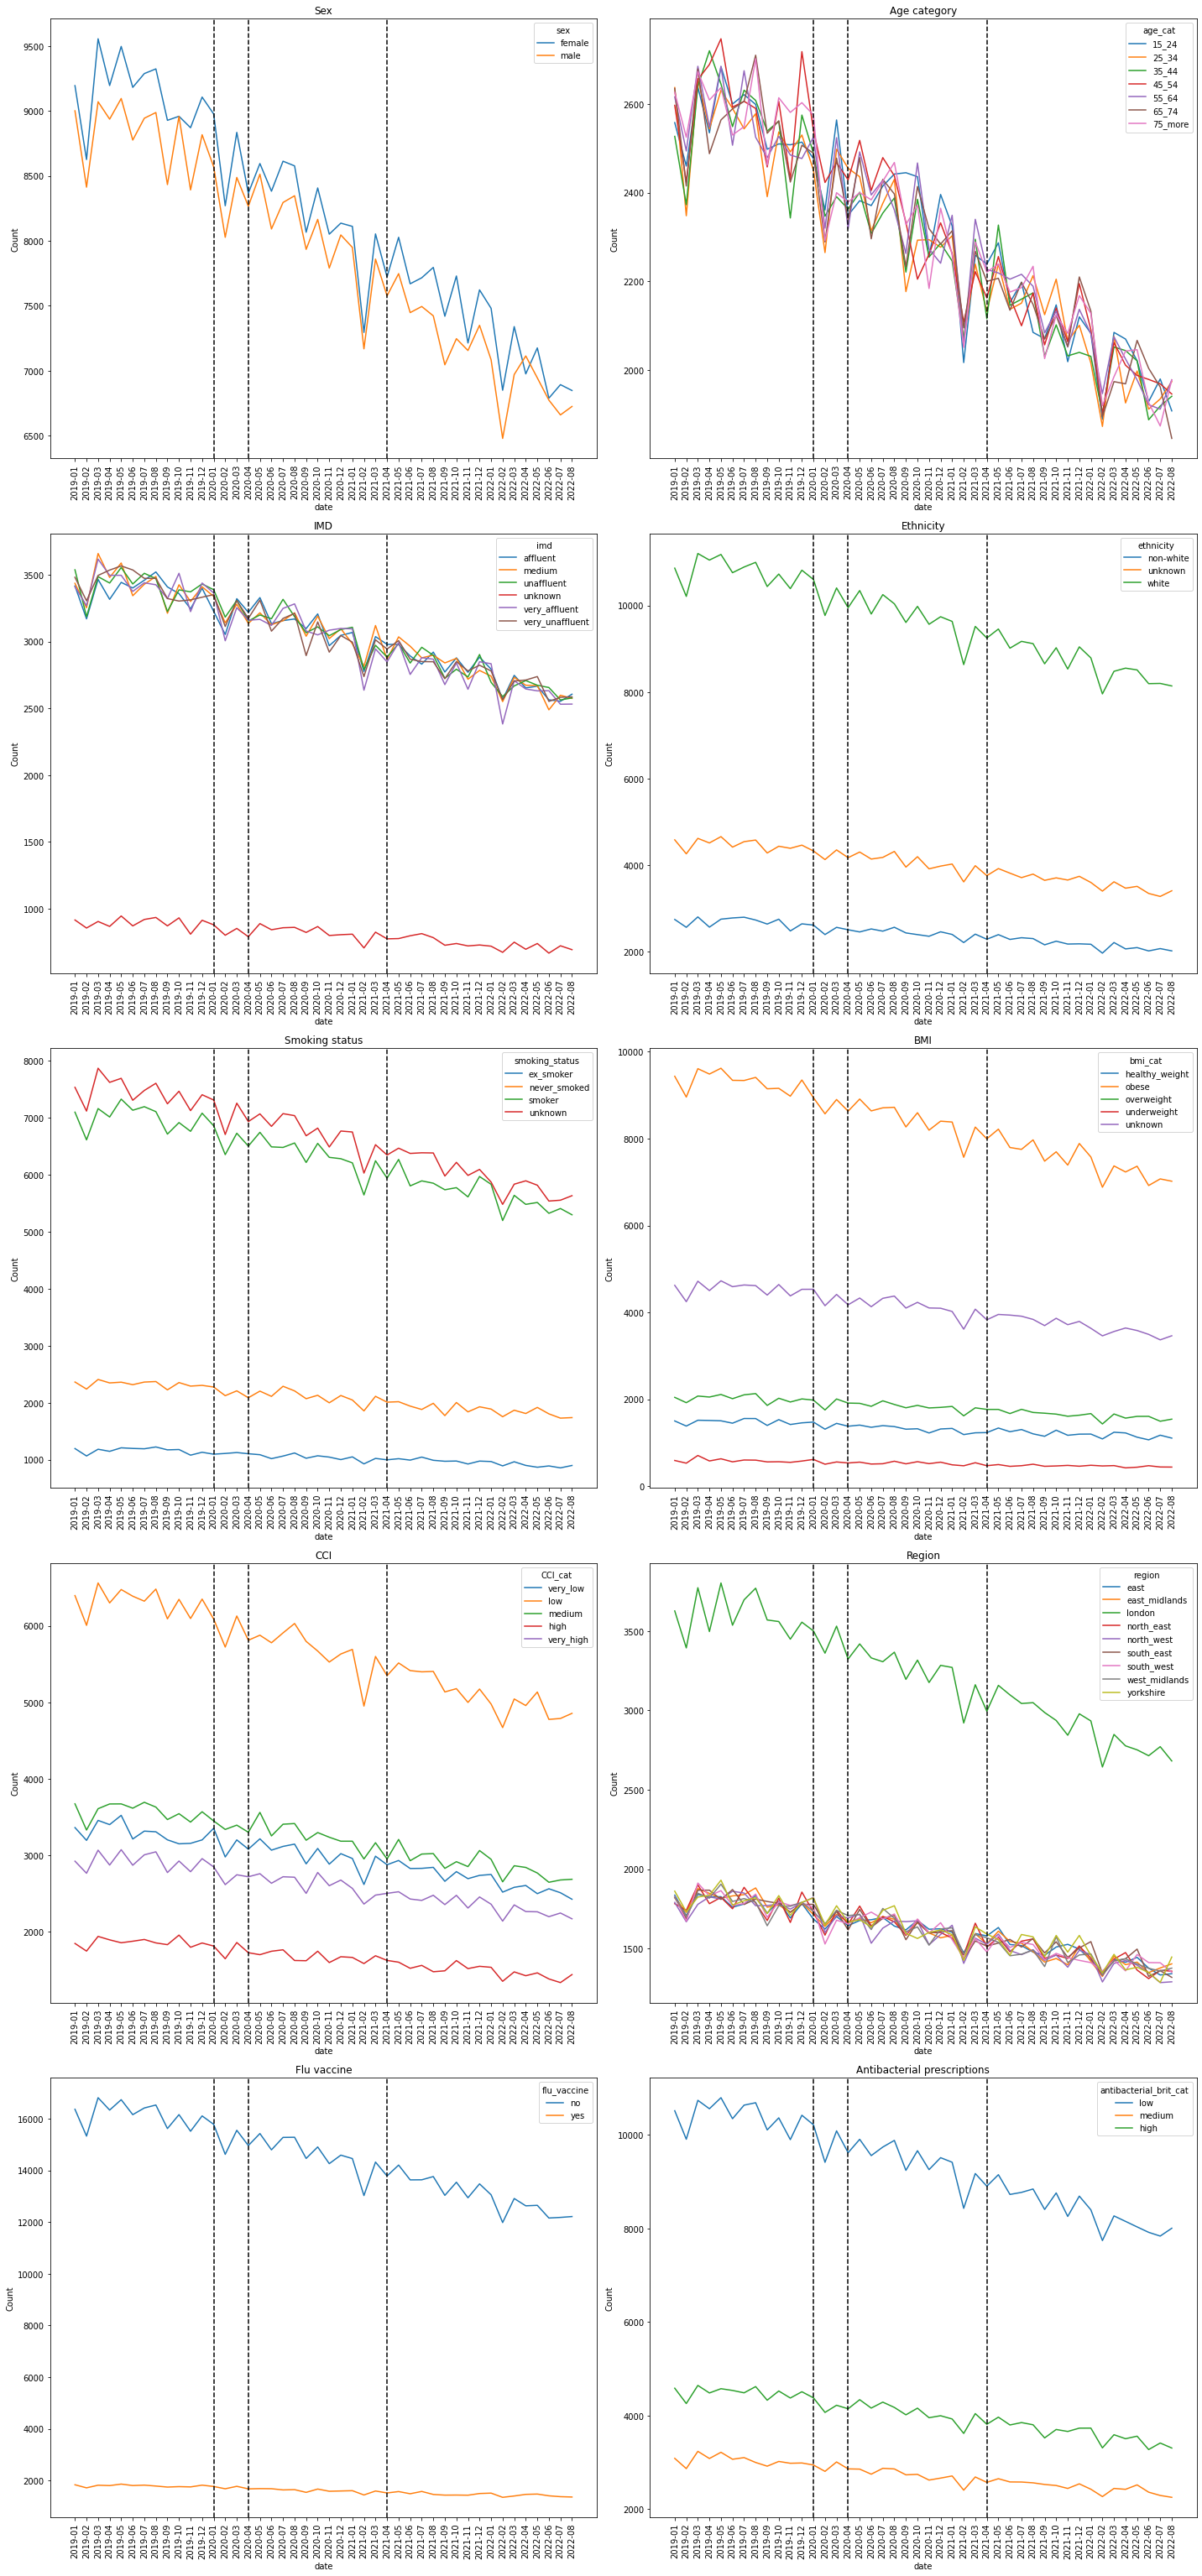

In [153]:
fig, axes = plt.subplots(5,2,
                        figsize=(20, 45)
                        )
create_lineplot(data_urti_combined, 'sex', 'Sex', axes[0,0])
create_lineplot(data_urti_combined, 'age_cat', 'Age category', axes[0,1])
create_lineplot(data_urti_combined, 'imd', 'IMD', axes[1,0])
create_lineplot(data_urti_combined, 'ethnicity', 'Ethnicity', axes[1,1])
create_lineplot(data_urti_combined, 'smoking_status', 'Smoking status', axes[2,0])
create_lineplot(data_urti_combined, 'bmi_cat', 'BMI', axes[2,1])
create_lineplot(data_urti_combined, 'CCI_cat', 'CCI', axes[3,0])
create_lineplot(data_urti_combined, 'region', 'Region', axes[3,1])
create_lineplot(data_urti_combined, 'flu_vaccine', 'Flu vaccine', axes[4,0])
create_lineplot(data_urti_combined, 'antibacterial_brit_cat', 'Antibacterial prescriptions', axes[4,1])
# fig.delaxes(ax=axes[5,1])

# fig.suptitle('Risk Factors of urti_combined patients', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti_combined/risk_factors_cat_urti_combined.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics
We separate data of urti_combined to form four sub-datasets for 1) no antibiotics and incident admission, 2) with antibiotics and incident admission, 3) no antibiotics and prevalent admission, and 4) with antiobiotics and prevalent admission.

In [154]:
data_urti_combined = data_urti_combined[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 
                       'antibacterial_brit', 'urti_combined_ab_date', 'ab_type_cat', 'incdt_urti_combined_date', 'date',
                       'event_urti_combined_admitted', 'duration_urti_combined_admitted'
                        ]]

data_urti_combined.shape

(708278, 17)

In [155]:
#incident and prevalent infection 
data_urti_combined_incdt = data_urti_combined[data_urti_combined['incdt_urti_combined_date'] == 0]
data_urti_combined_prevl = data_urti_combined[data_urti_combined['incdt_urti_combined_date'] == 1]
#switch variable urti_combined_ab_date into a binary variable
data_urti_combined_incdt[['urti_combined_ab_date']] = data_urti_combined_incdt[['urti_combined_ab_date']].where(data_urti_combined_incdt[['urti_combined_ab_date']].isnull(), 1).fillna(0).astype(int)
data_urti_combined_prevl[['urti_combined_ab_date']] = data_urti_combined_prevl[['urti_combined_ab_date']].where(data_urti_combined_prevl[['urti_combined_ab_date']].isnull(), 1).fillna(0).astype(int)

#incident and prevalent infection stratified by sex categories
data_urti_combined_incdt_males = data_urti_combined_incdt[data_urti_combined_incdt['sex'] == 'male']
data_urti_combined_incdt_females = data_urti_combined_incdt[data_urti_combined_incdt['sex'] == 'female']
data_urti_combined_prevl_males = data_urti_combined_prevl[data_urti_combined_prevl['sex'] == 'male']
data_urti_combined_prevl_females = data_urti_combined_prevl[data_urti_combined_prevl['sex'] == 'female']

#incident and prevalent infection stratified by age categories
data_urti_combined_incdt_15_24 = data_urti_combined_incdt[data_urti_combined_incdt['age_cat'] == '15_24']
data_urti_combined_incdt_25_34 = data_urti_combined_incdt[data_urti_combined_incdt['age_cat'] == '25_34']
data_urti_combined_incdt_35_44 = data_urti_combined_incdt[data_urti_combined_incdt['age_cat'] == '35_44']
data_urti_combined_incdt_45_54 = data_urti_combined_incdt[data_urti_combined_incdt['age_cat'] == '45_54']
data_urti_combined_incdt_55_64 = data_urti_combined_incdt[data_urti_combined_incdt['age_cat'] == '55_64']
data_urti_combined_incdt_65_74 = data_urti_combined_incdt[data_urti_combined_incdt['age_cat'] == '65_74']
data_urti_combined_incdt_75_more = data_urti_combined_incdt[data_urti_combined_incdt['age_cat'] == '75_more']
data_urti_combined_prevl_15_24 = data_urti_combined_prevl[data_urti_combined_prevl['age_cat'] == '15_24']
data_urti_combined_prevl_25_34 = data_urti_combined_prevl[data_urti_combined_prevl['age_cat'] == '25_34']
data_urti_combined_prevl_35_44 = data_urti_combined_prevl[data_urti_combined_prevl['age_cat'] == '35_44']
data_urti_combined_prevl_45_54 = data_urti_combined_prevl[data_urti_combined_prevl['age_cat'] == '45_54']
data_urti_combined_prevl_55_64 = data_urti_combined_prevl[data_urti_combined_prevl['age_cat'] == '55_64']
data_urti_combined_prevl_65_74 = data_urti_combined_prevl[data_urti_combined_prevl['age_cat'] == '65_74']
data_urti_combined_prevl_75_more = data_urti_combined_prevl[data_urti_combined_prevl['age_cat'] == '75_more']

data_urti_combined_incdt_prepandemic = data_urti_combined_incdt[data_urti_combined_incdt['date'] <= '2019-12']
data_urti_combined_incdt_during_pandemic = data_urti_combined_incdt[(data_urti_combined_incdt['date'] >= '2020-03') & (data_urti_combined_incdt['date']<= '2021-03')]
data_urti_combined_incdt_post_2nd_lockdown = data_urti_combined_incdt[data_urti_combined_incdt['date'] <= '2021-04']
data_urti_combined_prevl_prepandemic = data_urti_combined_prevl[data_urti_combined_prevl['date'] <= '2019-12']
data_urti_combined_prevl_during_pandemic = data_urti_combined_prevl[(data_urti_combined_prevl['date'] >= '2020-03') & (data_urti_combined_prevl['date']<= '2021-03')]
data_urti_combined_prevl_post_2nd_lockdown = data_urti_combined_prevl[data_urti_combined_prevl['date'] <= '2021-04']

# #incident and prevalent infection stratified by ab categories
# data_urti_combined_incdt_abtype_0 = data_urti_combined_incdt[data_urti_combined_incdt['ab_type_cat'] == data_urti_combined['ab_type_cat'].unique()[0]]
# data_urti_combined_incdt_abtype_1 = data_urti_combined_incdt[data_urti_combined_incdt['ab_type_cat'] == data_urti_combined['ab_type_cat'].unique()[1]]
# data_urti_combined_incdt_abtype_2 = data_urti_combined_incdt[data_urti_combined_incdt['ab_type_cat'] == data_urti_combined['ab_type_cat'].unique()[2]]
# data_urti_combined_incdt_abtype_3 = data_urti_combined_incdt[data_urti_combined_incdt['ab_type_cat'] == data_urti_combined['ab_type_cat'].unique()[3]]
# data_urti_combined_prevl_abtype_0 = data_urti_combined_prevl[data_urti_combined_prevl['ab_type_cat'] == data_urti_combined['ab_type_cat'].unique()[0]]
# data_urti_combined_prevl_abtype_1 = data_urti_combined_prevl[data_urti_combined_prevl['ab_type_cat'] == data_urti_combined['ab_type_cat'].unique()[1]]
# data_urti_combined_prevl_abtype_2 = data_urti_combined_prevl[data_urti_combined_prevl['ab_type_cat'] == data_urti_combined['ab_type_cat'].unique()[2]]
# data_urti_combined_prevl_abtype_3 = data_urti_combined_prevl[data_urti_combined_prevl['ab_type_cat'] == data_urti_combined['ab_type_cat'].unique()[3]]

# #incident and prevalent infection with antibiotics type
# data_urti_combined_incdt_abs = data_urti_combined_incdt[data_urti_combined_incdt['urti_combined_ab_date'] == 1]
# data_urti_combined_prevl_abs = data_urti_combined_prevl[data_urti_combined_prevl['urti_combined_ab_date'] == 1]

# no antibiotics and incident hospital admission
data_urti_combined_no_abs_incdt = data_urti_combined[data_urti_combined['urti_combined_ab_date'].isnull()] #gp_cons_urti_combined_ab
data_urti_combined_no_abs_incdt = data_urti_combined_no_abs_incdt[data_urti_combined_no_abs_incdt['incdt_urti_combined_date'] == 0]

# with antibiotics and incident hospital admission
data_urti_combined_abs_incdt = data_urti_combined[data_urti_combined['urti_combined_ab_date'].notnull()]
data_urti_combined_abs_incdt = data_urti_combined_abs_incdt[data_urti_combined_abs_incdt['incdt_urti_combined_date'] == 0]

# no antibiotics and prevalent hospital admission
data_urti_combined_no_abs_prevl = data_urti_combined[data_urti_combined['urti_combined_ab_date'].isnull()]
data_urti_combined_no_abs_prevl = data_urti_combined_no_abs_prevl[data_urti_combined_no_abs_prevl['incdt_urti_combined_date'] == 1]

# with antibiotics and prevalent hospital admission
data_urti_combined_abs_prevl = data_urti_combined[data_urti_combined['urti_combined_ab_date'].notnull()]
data_urti_combined_abs_prevl = data_urti_combined_abs_prevl[data_urti_combined_abs_prevl['incdt_urti_combined_date'] == 1]

print(f'shape of data_urti_combined_incdt: {data_urti_combined_incdt.shape}')
print(f'shape of data_urti_combined_prevl: {data_urti_combined_prevl.shape}')
print(f'shape of data_urti_combined_no_abs_incdt: {data_urti_combined_no_abs_incdt.shape}')
print(f'shape of data_urti_combined_abs_incdt: {data_urti_combined_abs_incdt.shape}')
print(f'shape of data_urti_combined_no_abs_prevl: {data_urti_combined_no_abs_prevl.shape}')
print(f'shape of data_urti_combined_abs_prevl: {data_urti_combined_abs_prevl.shape}')
print(f'\nvalue counts of data_urti_combined_no_abs_incdt: \n{data_urti_combined_no_abs_incdt.event_urti_combined_admitted.value_counts()}')
print(f'value counts of data_urti_combined_abs_incdt: \n{data_urti_combined_abs_incdt.event_urti_combined_admitted.value_counts()}')
print(f'value counts of data_urti_combined_no_abs_prevl: \n{data_urti_combined_no_abs_prevl.event_urti_combined_admitted.value_counts()}')
print(f'value counts of data_urti_combined_abs_prevl: \n{data_urti_combined_abs_prevl.event_urti_combined_admitted.value_counts()}')

shape of data_urti_combined_incdt: (637804, 17)
shape of data_urti_combined_prevl: (70474, 17)
shape of data_urti_combined_no_abs_incdt: (574352, 17)
shape of data_urti_combined_abs_incdt: (63452, 17)
shape of data_urti_combined_no_abs_prevl: (63447, 17)
shape of data_urti_combined_abs_prevl: (7027, 17)

value counts of data_urti_combined_no_abs_incdt: 
0.0    570098
1.0      4254
Name: event_urti_combined_admitted, dtype: int64
value counts of data_urti_combined_abs_incdt: 
0.0    62969
1.0      483
Name: event_urti_combined_admitted, dtype: int64
value counts of data_urti_combined_no_abs_prevl: 
0.0    62966
1.0      481
Name: event_urti_combined_admitted, dtype: int64
value counts of data_urti_combined_abs_prevl: 
0.0    6987
1.0      40
Name: event_urti_combined_admitted, dtype: int64


In [156]:
#store data for plotting hosp admission counts and percentages
%store data_urti_combined
# save data
data_urti_combined.to_csv('../output/hospitalisation_prediction_urti_combined/data_urti_combined.csv')

Stored 'data_urti_combined' (DataFrame)


## 5- cox modelling for hospital admissions
### 5-1- incident urti_combined with no antibiotics

<lifelines.CoxPHFitter: fitted with 430764 total observations, 427564 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 430764
number of events observed = 3200
   partial log-likelihood = -41486.48
         time fit was run = 2022-11-17 16:12:08 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.06       1.06       0.05            -0.04             0.16                 0.96                 1.17
CCI_cat[T.medium]               -0.03       0.97       0.06            -0.14             0.08                 0.87                 1.09
CCI_cat[T.high]                  0.10       1.11       0.07            -0.03             0.24                 0.97                 1.27
CCI_cat[T.very_high]             0.01       1.01       0.06            -0.11             0.13                 0.89                 1.13
age_cat[T.25_34]                 0.11       1.12       0.07            -0.02             0.24                 0.98                 1.28
age_cat[T.35_44]                 0.12       1.12       0.07            -0.02             0.25                 0.98                 1.28
age_cat[T.45_54]                 0.07       1.07       0.07            -0.06             0.20                 0.94                 1.22
age_cat[T.55_64]                 0.09       1.10       0.07            -0.04             0.22                 0.96                 1.25
age_cat[T.65_74]                 0.11       1.11       0.07            -0.03             0.24                 0.97                 1.27
age_cat[T.75_more]               0.14       1.15       0.07             0.01             0.27                 1.01                 1.31
antibacterial_brit              -0.01       0.99       0.01            -0.03             0.02                 0.97                 1.02
bmi_cat[T.obese]                 0.04       1.04       0.07            -0.09             0.17                 0.91                 1.19
bmi_cat[T.overweight]            0.10       1.10       0.08            -0.06             0.26                 0.94                 1.30
bmi_cat[T.underweight]           0.18       1.19       0.11            -0.04             0.40                 0.96                 1.49
bmi_cat[T.unknown]               0.07       1.07       0.07            -0.07             0.21                 0.93                 1.24
ethnicity[T.unknown]             0.02       1.02       0.06            -0.09             0.13                 0.91                 1.14
ethnicity[T.white]              -0.03       0.97       0.05            -0.13             0.07                 0.88                 1.07
flu_vaccine[T.yes]              -0.02       0.98       0.06            -0.14             0.10                 0.87                 1.10
imd[T.medium]                    0.01       1.01       0.06            -0.10             0.12                 0.91                 1.13
imd[T.unaffluent]               -0.02       0.98       0.06            -0.13             0.09                 0.88                 1.10
imd[T.unknown]                   0.01       1.01       0.09            -0.16             0.18                 0.85                 1.20
imd[T.very_affluent]            -0.00       1.00       0.06            -0.11             0.11                 0.89                 1.12
imd[T.very_unaffluent]          -0.06       0.94       0.06            -0.17             0.06                 0.84                 1.06
region[T.east_midlands]          0.10       1.11       0.08            -0.06             0.26                 0.95                 1.29
region[T.london]                 0.07       1

12773


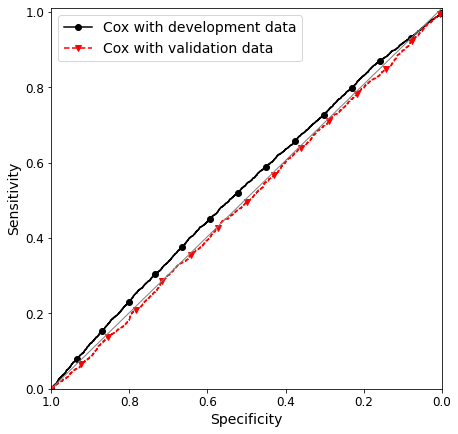

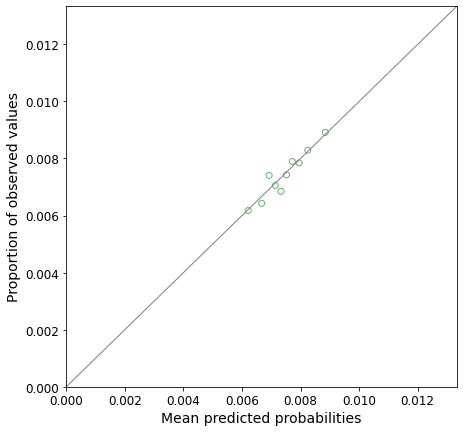

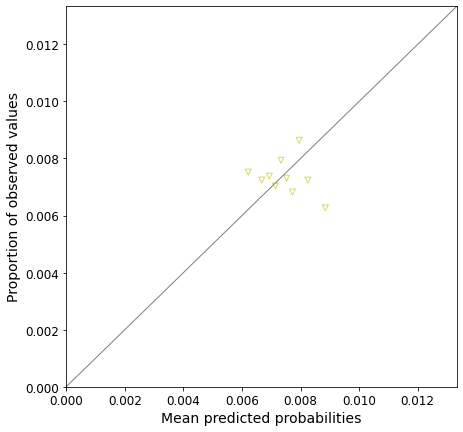

In [157]:
#data prep
data, data_urti_combined_no_abs_incdt_enc = cox_data_prep(data_urti_combined_no_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

#make summary table
make_summary_table('urti_combined', 'no_abs_incdt', data_urti_combined_no_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('urti_combined', 'no_abs_incdt', data_urti_combined_no_abs_incdt)

try:
    #build cox model 
    cph_urti_combined_no_abs_incdt, data_urti_combined_no_abs_incdt_train, data_urti_combined_no_abs_incdt_test = cox_model_build('urti_combined', 'no_abs_incdt', data_urti_combined_no_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_urti_combined_no_abs_incdt, '../output/hospitalisation_prediction_urti_combined/', 'betas_cph_urti_combined_no_abs_incdt.csv', data_urti_combined_no_abs_incdt_enc, data_urti_combined_no_abs_incdt, 'sum_betas_cph_urti_combined_no_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_urti_combined_no_abs_incdt, 'event_urti_combined_admitted', data_urti_combined_no_abs_incdt_train, data_urti_combined_no_abs_incdt_test, '../output/hospitalisation_prediction_urti_combined', 'roc_cph_urti_combined_no_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_urti_combined_no_abs_incdt, data_urti_combined_no_abs_incdt_train, 'event_urti_combined_admitted', data_urti_combined_no_abs_incdt_test, '../output/hospitalisation_prediction_urti_combined/', 'calibration_cph_urti_combined_no_abs_incdt_train.jpg', 'calibration_cph_urti_combined_no_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_urti_combined_no_abs_incdt, 'urti_combined', 'no_abs_incdt', data_urti_combined_no_abs_incdt_train, data_urti_combined_no_abs_incdt_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-2- incident urti_combined with antibiotics

<lifelines.CoxPHFitter: fitted with 47589 total observations, 47232 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 47589
number of events observed = 357
   partial log-likelihood = -3818.36
         time fit was run = 2022-11-17 16:13:02 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.05       1.06       0.15            -0.23             0.34                 0.79                 1.41
CCI_cat[T.medium]               -0.03       0.97       0.17            -0.36             0.30                 0.70                 1.35
CCI_cat[T.high]                 -0.12       0.89       0.21            -0.52             0.29                 0.59                 1.34
CCI_cat[T.very_high]            -0.41       0.66       0.20            -0.80            -0.02                 0.45                 0.98
age_cat[T.25_34]                 0.15       1.16       0.21            -0.26             0.55                 0.77                 1.74
age_cat[T.35_44]                -0.03       0.97       0.22            -0.45             0.39                 0.64                 1.48
age_cat[T.45_54]                 0.25       1.28       0.20            -0.15             0.64                 0.86                 1.90
age_cat[T.55_64]                 0.27       1.31       0.20            -0.12             0.66                 0.88                 1.94
age_cat[T.65_74]                 0.21       1.23       0.20            -0.19             0.61                 0.82                 1.83
age_cat[T.75_more]               0.28       1.32       0.20            -0.11             0.67                 0.89                 1.96
antibacterial_brit              -0.05       0.95       0.04            -0.12             0.02                 0.88                 1.02
bmi_cat[T.obese]                -0.28       0.76       0.18            -0.63             0.07                 0.53                 1.07
bmi_cat[T.overweight]           -0.60       0.55       0.25            -1.08            -0.11                 0.34                 0.89
bmi_cat[T.underweight]          -0.07       0.93       0.31            -0.69             0.54                 0.50                 1.72
bmi_cat[T.unknown]              -0.30       0.74       0.19            -0.68             0.08                 0.51                 1.09
ethnicity[T.unknown]            -0.12       0.88       0.17            -0.46             0.21                 0.63                 1.24
ethnicity[T.white]              -0.04       0.96       0.15            -0.34             0.25                 0.71                 1.28
flu_vaccine[T.yes]               0.36       1.44       0.15             0.07             0.66                 1.07                 1.94
imd[T.medium]                   -0.10       0.91       0.17            -0.42             0.23                 0.66                 1.26
imd[T.unaffluent]               -0.08       0.93       0.17            -0.40             0.25                 0.67                 1.28
imd[T.unknown]                  -0.58       0.56       0.32            -1.21             0.06                 0.30                 1.06
imd[T.very_affluent]             0.01       1.01       0.16            -0.30             0.33                 0.74                 1.39
imd[T.very_unaffluent]          -0.38       0.68       0.18            -0.74            -0.03                 0.48                 0.97
region[T.east_midlands]         -0.20       0.82       0.23            -0.65             0.25                 0.52                 1.28
region[T.london]                -0.21       0.81  

12801


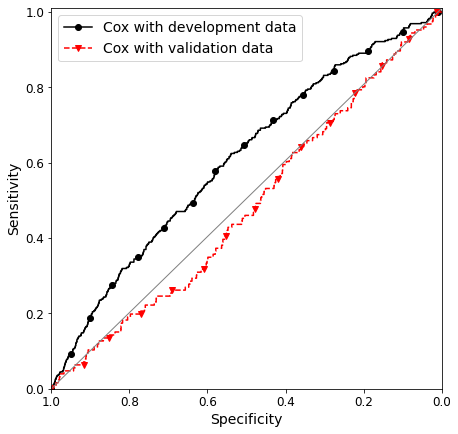

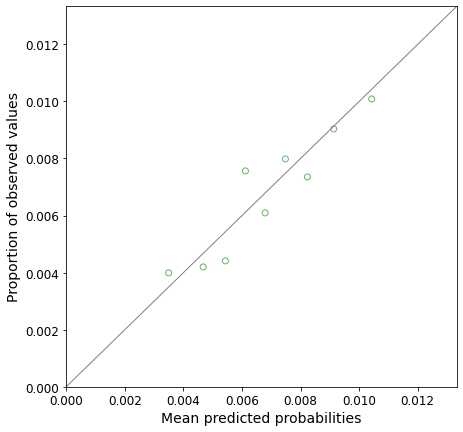

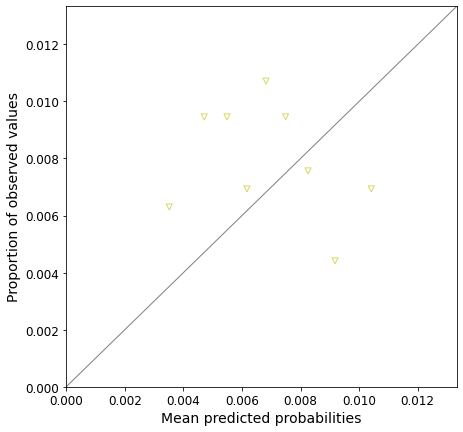

In [158]:
#data prep
data, data_urti_combined_abs_incdt_enc = cox_data_prep(data_urti_combined_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

#make summary table
make_summary_table('urti_combined', 'abs_incdt', data_urti_combined_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('urti_combined', 'abs_incdt', data_urti_combined_abs_incdt)

try:
    #build cox model 
    cph_urti_combined_abs_incdt, data_urti_combined_abs_incdt_train, data_urti_combined_abs_incdt_test = cox_model_build('urti_combined', 'abs_incdt', data_urti_combined_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_urti_combined_abs_incdt, '../output/hospitalisation_prediction_urti_combined/', 'betas_cph_urti_combined_abs_incdt.csv', data_urti_combined_abs_incdt_enc, data_urti_combined_abs_incdt, 'sum_betas_cph_urti_combined_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_urti_combined_abs_incdt, 'event_urti_combined_admitted', data_urti_combined_abs_incdt_train, data_urti_combined_abs_incdt_test, '../output/hospitalisation_prediction_urti_combined', 'roc_cph_urti_combined_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_urti_combined_abs_incdt, data_urti_combined_abs_incdt_train, 'event_urti_combined_admitted', data_urti_combined_abs_incdt_test, '../output/hospitalisation_prediction_urti_combined/', 'calibration_cph_urti_combined_abs_incdt_train.jpg', 'calibration_cph_urti_combined_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_urti_combined_abs_incdt, 'urti_combined', 'abs_incdt', data_urti_combined_abs_incdt_train, data_urti_combined_abs_incdt_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-3- prevalent urti_combined with no antibiotics

<lifelines.CoxPHFitter: fitted with 47585 total observations, 47218 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 47585
number of events observed = 367
   partial log-likelihood = -3933.04
         time fit was run = 2022-11-17 16:13:16 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.13       0.88       0.15            -0.42             0.16                 0.66                 1.17
CCI_cat[T.medium]               -0.06       0.95       0.16            -0.38             0.26                 0.69                 1.30
CCI_cat[T.high]                 -0.44       0.64       0.23            -0.89             0.01                 0.41                 1.01
CCI_cat[T.very_high]             0.08       1.08       0.17            -0.25             0.41                 0.78                 1.50
age_cat[T.25_34]                 0.26       1.29       0.20            -0.14             0.65                 0.87                 1.92
age_cat[T.35_44]                 0.02       1.02       0.21            -0.40             0.44                 0.67                 1.55
age_cat[T.45_54]                 0.36       1.43       0.20            -0.03             0.75                 0.97                 2.11
age_cat[T.55_64]                 0.39       1.48       0.20             0.01             0.78                 1.01                 2.18
age_cat[T.65_74]                 0.26       1.30       0.20            -0.13             0.66                 0.88                 1.93
age_cat[T.75_more]               0.07       1.08       0.21            -0.34             0.49                 0.71                 1.63
antibacterial_brit               0.00       1.00       0.04            -0.07             0.08                 0.93                 1.08
bmi_cat[T.obese]                 0.01       1.01       0.19            -0.37             0.39                 0.69                 1.48
bmi_cat[T.overweight]           -0.07       0.93       0.24            -0.54             0.40                 0.58                 1.49
bmi_cat[T.underweight]           0.16       1.18       0.32            -0.47             0.80                 0.63                 2.22
bmi_cat[T.unknown]              -0.09       0.91       0.21            -0.51             0.32                 0.60                 1.37
ethnicity[T.unknown]            -0.09       0.91       0.16            -0.42             0.23                 0.66                 1.26
ethnicity[T.white]              -0.15       0.86       0.15            -0.43             0.13                 0.65                 1.14
flu_vaccine[T.yes]              -0.03       0.97       0.18            -0.38             0.31                 0.69                 1.37
imd[T.medium]                    0.04       1.05       0.17            -0.28             0.37                 0.75                 1.45
imd[T.unaffluent]                0.09       1.09       0.16            -0.23             0.41                 0.80                 1.51
imd[T.unknown]                  -0.16       0.85       0.28            -0.71             0.38                 0.49                 1.46
imd[T.very_affluent]            -0.10       0.91       0.17            -0.43             0.24                 0.65                 1.27
imd[T.very_unaffluent]          -0.16       0.85       0.17            -0.50             0.18                 0.60                 1.20
region[T.east_midlands]          0.21       1.24       0.24            -0.26             0.69                 0.77                 1.99
region[T.london]                 0.26       1.30  

12779


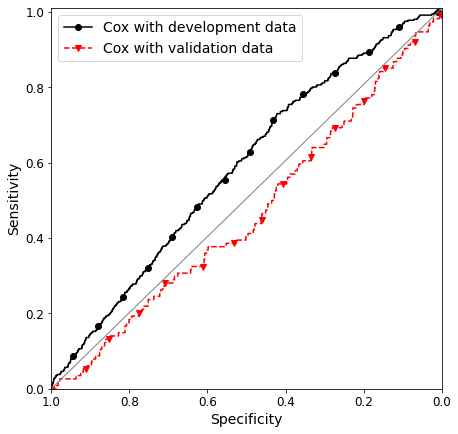

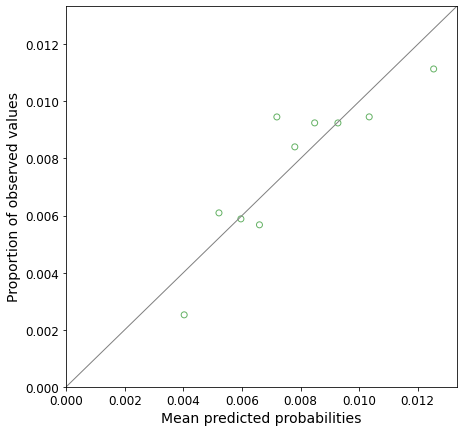

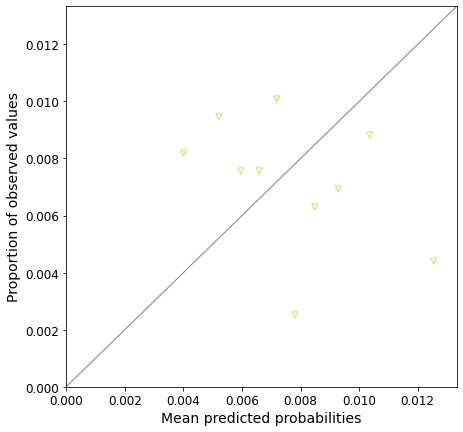

In [159]:
#data prep
data, data_urti_combined_no_abs_prevl_enc = cox_data_prep(data_urti_combined_no_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

#make summary table
make_summary_table('urti_combined', 'no_abs_prevl', data_urti_combined_no_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('urti_combined', 'no_abs_prevl', data_urti_combined_no_abs_prevl)

try:
    #build cox model 
    cph_urti_combined_no_abs_prevl, data_urti_combined_no_abs_prevl_train, data_urti_combined_no_abs_prevl_test = cox_model_build('urti_combined', 'no_abs_prevl', data_urti_combined_no_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:    
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_urti_combined_no_abs_prevl, '../output/hospitalisation_prediction_urti_combined/', 'betas_cph_urti_combined_no_abs_prevl.csv', data_urti_combined_no_abs_prevl_enc, data_urti_combined_no_abs_prevl, 'sum_betas_cph_urti_combined_no_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_urti_combined_no_abs_prevl, 'event_urti_combined_admitted', data_urti_combined_no_abs_prevl_train, data_urti_combined_no_abs_prevl_test, '../output/hospitalisation_prediction_urti_combined', 'roc_cph_urti_combined_no_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_urti_combined_no_abs_prevl, data_urti_combined_no_abs_prevl_train, 'event_urti_combined_admitted', data_urti_combined_no_abs_prevl_test, '../output/hospitalisation_prediction_urti_combined/', 'calibration_cph_urti_combined_no_abs_prevl_train.jpg', 'calibration_cph_urti_combined_no_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_urti_combined_no_abs_prevl, 'urti_combined', 'no_abs_prevl', data_urti_combined_no_abs_prevl_train, data_urti_combined_no_abs_prevl_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-4- prevalent urti_combined with antibiotics

<lifelines.CoxPHFitter: fitted with 5270 total observations, 5245 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 5270
number of events observed = 25
   partial log-likelihood = -198.67
         time fit was run = 2022-11-17 16:13:25 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.82       0.44       0.52            -1.85             0.20                 0.16                 1.23
CCI_cat[T.medium]               -1.43       0.24       0.79            -2.99             0.12                 0.05                 1.13
CCI_cat[T.high]                 -1.61       0.20       1.06            -3.70             0.47                 0.02                 1.60
CCI_cat[T.very_high]             0.04       1.04       0.52            -0.98             1.06                 0.37                 2.90
age_cat[T.25_34]                -1.45       0.23       1.12            -3.65             0.74                 0.03                 2.10
age_cat[T.35_44]                 0.34       1.41       0.65            -0.93             1.62                 0.39                 5.05
age_cat[T.45_54]                 0.14       1.15       0.67            -1.19             1.46                 0.31                 4.30
age_cat[T.55_64]                -0.75       0.47       0.87            -2.45             0.96                 0.09                 2.60
age_cat[T.65_74]                -0.41       0.66       0.77            -1.92             1.09                 0.15                 2.98
age_cat[T.75_more]              -0.11       0.89       0.71            -1.51             1.28                 0.22                 3.60
antibacterial_brit              -0.11       0.89       0.15            -0.41             0.18                 0.67                 1.20
bmi_cat[T.obese]                 0.23       1.26       0.76            -1.26             1.72                 0.28                 5.61
bmi_cat[T.overweight]           -0.19       0.83       1.01            -2.17             1.79                 0.11                 5.96
bmi_cat[T.underweight]           0.21       1.23       1.23            -2.21             2.63                 0.11                13.83
bmi_cat[T.unknown]               0.04       1.04       0.82            -1.58             1.65                 0.21                 5.20
ethnicity[T.unknown]             0.03       1.03       0.62            -1.19             1.24                 0.31                 3.45
ethnicity[T.white]              -0.27       0.76       0.58            -1.40             0.86                 0.25                 2.36
flu_vaccine[T.yes]              -0.32       0.73       0.74            -1.77             1.14                 0.17                 3.13
imd[T.medium]                    0.29       1.33       0.77            -1.22             1.79                 0.30                 6.01
imd[T.unaffluent]                0.55       1.73       0.73            -0.89             1.99                 0.41                 7.30
imd[T.unknown]                   1.07       2.93       0.92            -0.73             2.88                 0.48                17.87
imd[T.very_affluent]             0.76       2.14       0.69            -0.60             2.12                 0.55                 8.36
imd[T.very_unaffluent]           0.32       1.38       0.77            -1.19             1.83                 0.31                 6.21
region[T.east_midlands]         -0.43       0.65       0.92            -2.23             1.38                 0.11                 3.96
region[T.london]                 0.03       1.03       

12787


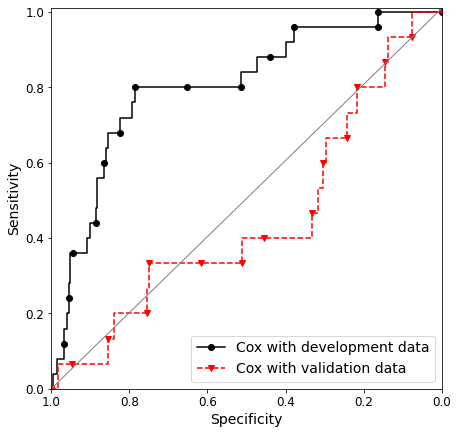

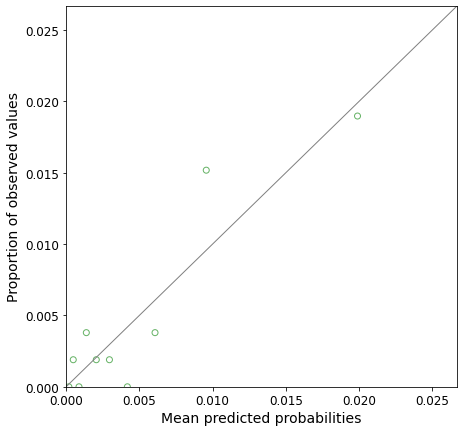

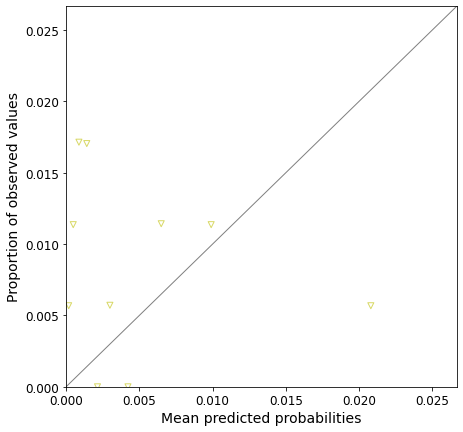

In [160]:
#data prep
data, data_urti_combined_abs_prevl_enc = cox_data_prep(data_urti_combined_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

#make summary table
make_summary_table('urti_combined', 'abs_prevl', data_urti_combined_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('urti_combined', 'abs_prevl', data_urti_combined_abs_prevl)

try:
    #build cox model 
    cph_urti_combined_abs_prevl, data_urti_combined_abs_prevl_train, data_urti_combined_abs_prevl_test = cox_model_build('urti_combined', 'abs_prevl', data_urti_combined_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_urti_combined_abs_prevl, '../output/hospitalisation_prediction_urti_combined/', 'betas_cph_urti_combined_abs_prevl.csv', data_urti_combined_abs_prevl_enc, data_urti_combined_abs_prevl, 'sum_betas_cph_urti_combined_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_urti_combined_abs_prevl, 'event_urti_combined_admitted', data_urti_combined_abs_prevl_train, data_urti_combined_abs_prevl_test, '../output/hospitalisation_prediction_urti_combined', 'roc_cph_urti_combined_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_urti_combined_abs_prevl, data_urti_combined_abs_prevl_train, 'event_urti_combined_admitted', data_urti_combined_abs_prevl_test, '../output/hospitalisation_prediction_urti_combined/', 'calibration_cph_urti_combined_abs_prevl_train.jpg', 'calibration_cph_urti_combined_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_urti_combined_abs_prevl, 'urti_combined', 'abs_prevl', data_urti_combined_abs_prevl_train, data_urti_combined_abs_prevl_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-5- incident urti_combined

In [161]:
#data prep
data, data_urti_combined_incdt_enc = cox_data_prep(data_urti_combined_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

#make summary tables from preped data
make_summary_table('urti_combined', 'incdt', data_urti_combined_incdt_enc)
make_summary_table_hosped('urti_combined', 'incdt', data_urti_combined_incdt)

try:
    cph_urti_combined_incdt, data_urti_combined_incdt_train, data_urti_combined_incdt_test = cox_model_abs_build('urti_combined', 'incdt', data_urti_combined_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_urti_combined_incdt, 'urti_combined', 'incdt', data_urti_combined_incdt_train, data_urti_combined_incdt_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 478353 total observations, 474812 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 478353
number of events observed = 3541
   partial log-likelihood = -46276.51
         time fit was run = 2022-11-17 16:14:01 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.01       1.01       0.05            -0.08             0.11                 0.92                 1.11
CCI_cat[T.medium]               -0.06       0.94       0.06            -0.17             0.05                 0.84                 1.05
CCI_cat[T.high]                  0.03       1.03       0.06            -0.09             0.16                 0.91                 1.17
CCI_cat[T.very_high]             0.00       1.00       0.06            -0.11             0.11                 0.90                 1.12
age_cat[T.25_34]                 0.15       1.16       0.06             0.02             0.27                 1.02                 1.31
age_cat[T.35_44]                 0.10       1.10       0.06            -0.03             0.22                 0.97                 1.25
age_cat[T.45_54]                 0.05       1.06       0.06            -0.07             0.18                 0.93                 1.20
age_cat[T.55_64]                 0.07       1.07       0.06            -0.06             0.19                 0.94                 1.21
age_cat[T.65_74]                 0.06       1.06       0.06            -0.07             0.19                 0.94                 1.20
age_cat[T.75_more]               0.09       1.09       0.06            -0.04             0.21                 0.96                 1.23
antibacterial_brit               0.00       1.00       0.01            -0.02             0.03                 0.98                 1.03
bmi_cat[T.obese]                 0.05       1.06       0.07            -0.07             0.18                 0.93                 1.20
bmi_cat[T.overweight]            0.10       1.11       0.08            -0.05             0.26                 0.95                 1.29
bmi_cat[T.underweight]           0.16       1.17       0.11            -0.05             0.37                 0.95                 1.45
bmi_cat[T.unknown]               0.10       1.10       0.07            -0.04             0.23                 0.96                 1.26
ethnicity[T.unknown]            -0.01       0.99       0.05            -0.12             0.10                 0.89                 1.10
ethnicity[T.white]              -0.00       1.00       0.05            -0.10             0.09                 0.91                 1.10
flu_vaccine[T.yes]               0.08       1.09       0.05            -0.02             0.19                 0.98                 1.21
imd[T.medium]                   -0.05       0.95       0.05            -0.15             0.06                 0.86                 1.06
imd[T.unaffluent]               -0.05       0.95       0.05            -0.15             0.06                 0.86                 1.06
imd[T.unknown]                  -0.01       0.99       0.08            -0.17             0.15                 0.84                 1.16
imd[T.very_affluent]            -0.05       0.96       0.05            -0.15             0.06                 0.86                 1.06
imd[T.very_unaffluent]          -0.13       0.88       0.05            -0.23            -0.02                 0.79                 0.98
region[T.east_midlands]          0.12       1.13       0.07            -0.02             0.27                 0.98                 1.30
region[T.london]                 0.00       1

13059


### 5-6- hospital admission related to prevalent urti_combined

In [162]:
#data prep
data, data_urti_combined_prevl_enc = cox_data_prep(data_urti_combined_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

#make summary tables from preped data
make_summary_table('urti_combined', 'prevl', data_urti_combined_prevl_enc)
make_summary_table_hosped('urti_combined', 'prevl', data_urti_combined_prevl)

try:
    cph_urti_combined_prevl, data_urti_combined_prevl_train, data_urti_combined_prevl_test = cox_model_abs_build('urti_combined', 'prevl', data_urti_combined_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_combined_prevl, 'urti_combined', 'prevl', data_urti_combined_prevl_train, data_urti_combined_prevl_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 52855 total observations, 52462 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 52855
number of events observed = 393
   partial log-likelihood = -4255.86
         time fit was run = 2022-11-17 16:14:30 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.01       0.99       0.15            -0.29             0.28                 0.75                 1.32
CCI_cat[T.medium]               -0.04       0.97       0.16            -0.36             0.29                 0.70                 1.33
CCI_cat[T.high]                 -0.23       0.80       0.21            -0.64             0.19                 0.53                 1.21
CCI_cat[T.very_high]             0.16       1.18       0.17            -0.16             0.49                 0.85                 1.63
age_cat[T.25_34]                 0.33       1.40       0.20            -0.05             0.72                 0.95                 2.05
age_cat[T.35_44]                 0.24       1.26       0.20            -0.16             0.63                 0.85                 1.87
age_cat[T.45_54]                 0.27       1.31       0.20            -0.12             0.66                 0.89                 1.93
age_cat[T.55_64]                 0.44       1.55       0.19             0.06             0.81                 1.06                 2.25
age_cat[T.65_74]                 0.07       1.07       0.21            -0.34             0.48                 0.71                 1.61
age_cat[T.75_more]               0.17       1.19       0.20            -0.23             0.57                 0.80                 1.77
antibacterial_brit               0.00       1.00       0.04            -0.07             0.07                 0.94                 1.08
bmi_cat[T.obese]                 0.08       1.09       0.19            -0.29             0.45                 0.75                 1.57
bmi_cat[T.overweight]           -0.19       0.83       0.24            -0.67             0.29                 0.51                 1.33
bmi_cat[T.underweight]          -0.21       0.81       0.36            -0.92             0.50                 0.40                 1.65
bmi_cat[T.unknown]              -0.06       0.94       0.20            -0.46             0.34                 0.63                 1.41
ethnicity[T.unknown]            -0.05       0.95       0.16            -0.37             0.27                 0.69                 1.31
ethnicity[T.white]              -0.04       0.96       0.14            -0.32             0.24                 0.73                 1.28
flu_vaccine[T.yes]              -0.19       0.82       0.18            -0.55             0.16                 0.58                 1.18
imd[T.medium]                   -0.08       0.92       0.16            -0.41             0.24                 0.67                 1.27
imd[T.unaffluent]                0.18       1.19       0.15            -0.13             0.48                 0.88                 1.61
imd[T.unknown]                  -0.19       0.82       0.27            -0.72             0.33                 0.49                 1.39
imd[T.very_affluent]            -0.09       0.91       0.16            -0.42             0.23                 0.66                 1.26
imd[T.very_unaffluent]          -0.20       0.82       0.17            -0.53             0.13                 0.59                 1.14
region[T.east_midlands]          0.01       1.01       0.23            -0.45             0.47                 0.64                 1.60
region[T.london]                 0.17       1.19  

13062


### 5-7- hospital admission related to incident urti_combined with prescribed antibiotics categories

In [163]:
#data prep
data, data_urti_combined_incdt_abs_enc = cox_data_prep(data_urti_combined_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_incdt_abs, data_urti_combined_incdt_abs_train, data_urti_combined_incdt_abs_test = cox_model_ab_type_build('urti_combined', 'incdt_ab_type', data_urti_combined_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_urti_combined_incdt_abs, 'urti_combined', 'incdt_abs', data_urti_combined_incdt_abs_train, data_urti_combined_incdt_abs_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 478353 total observations, 474812 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 478353
number of events observed = 3541
   partial log-likelihood = -46275.47
         time fit was run = 2022-11-17 16:14:46 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.01       1.01       0.05            -0.08             0.11                 0.92                 1.11
CCI_cat[T.medium]               -0.06       0.94       0.06            -0.17             0.05                 0.84                 1.05
CCI_cat[T.high]                  0.03       1.03       0.06            -0.09             0.16                 0.91                 1.17
CCI_cat[T.very_high]             0.00       1.00       0.06            -0.11             0.11                 0.90                 1.12
ab_type_cat[T.Doxycycline]       0.43       1.53       0.37            -0.29             1.14                 0.75                 3.14
ab_type_cat[T.no]               -0.07       0.93       0.21            -0.48             0.34                 0.62                 1.40
ab_type_cat[T.other]            -0.05       0.95       0.22            -0.47             0.38                 0.62                 1.46
age_cat[T.25_34]                 0.15       1.16       0.06             0.02             0.27                 1.02                 1.31
age_cat[T.35_44]                 0.10       1.10       0.06            -0.03             0.22                 0.97                 1.25
age_cat[T.45_54]                 0.05       1.06       0.06            -0.07             0.18                 0.93                 1.20
age_cat[T.55_64]                 0.07       1.07       0.06            -0.06             0.19                 0.94                 1.21
age_cat[T.65_74]                 0.06       1.06       0.06            -0.07             0.19                 0.94                 1.20
age_cat[T.75_more]               0.09       1.09       0.06            -0.04             0.21                 0.96                 1.23
antibacterial_brit               0.00       1.00       0.01            -0.02             0.03                 0.98                 1.03
bmi_cat[T.obese]                 0.05       1.06       0.07            -0.07             0.18                 0.93                 1.20
bmi_cat[T.overweight]            0.10       1.11       0.08            -0.05             0.26                 0.95                 1.29
bmi_cat[T.underweight]           0.16       1.17       0.11            -0.05             0.37                 0.95                 1.45
bmi_cat[T.unknown]               0.10       1.10       0.07            -0.04             0.23                 0.96                 1.26
ethnicity[T.unknown]            -0.01       0.99       0.05            -0.12             0.10                 0.89                 1.10
ethnicity[T.white]              -0.00       1.00       0.05            -0.10             0.09                 0.91                 1.10
flu_vaccine[T.yes]               0.08       1.09       0.05            -0.02             0.19                 0.98                 1.21
imd[T.medium]                   -0.05       0.95       0.05            -0.15             0.06                 0.86                 1.06
imd[T.unaffluent]               -0.05       0.95       0.05            -0.15             0.06                 0.86                 1.06
imd[T.unknown]                  -0.01       0.99       0.08            -0.17             0.15                 0.84                 1.16
imd[T.very_affluent]            -0.04       0

13617


### 5-8- hospital admission related to prevalent urti_combined with prescribed antibiotics categories

In [164]:
#data prep
data, data_urti_combined_prevl_abs_enc = cox_data_prep(data_urti_combined_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_prevl_abs, data_urti_combined_prevl_abs_train, data_urti_combined_prevl_abs_test = cox_model_ab_type_build('urti_combined', 'prevl_ab_type', data_urti_combined_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_urti_combined_prevl_abs, 'urti_combined', 'prevl_abs', data_urti_combined_prevl_abs_train, data_urti_combined_prevl_abs_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 52855 total observations, 52462 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 52855
number of events observed = 393
   partial log-likelihood = -4255.61
         time fit was run = 2022-11-17 16:15:12 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.01       0.99       0.15            -0.29             0.28                 0.75                 1.32
CCI_cat[T.medium]               -0.03       0.97       0.16            -0.36             0.29                 0.70                 1.33
CCI_cat[T.high]                 -0.23       0.80       0.21            -0.64             0.19                 0.53                 1.21
CCI_cat[T.very_high]             0.16       1.18       0.17            -0.16             0.49                 0.85                 1.63
ab_type_cat[T.Doxycycline]      -0.01       0.99       1.16            -2.27             2.25                 0.10                 9.52
ab_type_cat[T.no]               -0.18       0.84       0.58            -1.31             0.96                 0.27                 2.61
ab_type_cat[T.other]            -0.40       0.67       0.61            -1.59             0.79                 0.20                 2.20
age_cat[T.25_34]                 0.33       1.40       0.20            -0.05             0.72                 0.95                 2.05
age_cat[T.35_44]                 0.23       1.26       0.20            -0.16             0.63                 0.85                 1.87
age_cat[T.45_54]                 0.27       1.31       0.20            -0.12             0.66                 0.89                 1.93
age_cat[T.55_64]                 0.44       1.55       0.19             0.06             0.81                 1.06                 2.25
age_cat[T.65_74]                 0.07       1.07       0.21            -0.34             0.48                 0.71                 1.61
age_cat[T.75_more]               0.17       1.19       0.20            -0.23             0.57                 0.80                 1.77
antibacterial_brit               0.00       1.00       0.04            -0.07             0.07                 0.94                 1.08
bmi_cat[T.obese]                 0.08       1.09       0.19            -0.29             0.45                 0.75                 1.57
bmi_cat[T.overweight]           -0.19       0.83       0.24            -0.67             0.29                 0.51                 1.33
bmi_cat[T.underweight]          -0.21       0.81       0.36            -0.92             0.50                 0.40                 1.65
bmi_cat[T.unknown]              -0.06       0.94       0.20            -0.46             0.34                 0.63                 1.41
ethnicity[T.unknown]            -0.05       0.95       0.16            -0.37             0.27                 0.69                 1.31
ethnicity[T.white]              -0.04       0.96       0.14            -0.32             0.24                 0.73                 1.28
flu_vaccine[T.yes]              -0.19       0.82       0.18            -0.55             0.16                 0.58                 1.18
imd[T.medium]                   -0.08       0.92       0.16            -0.41             0.24                 0.67                 1.27
imd[T.unaffluent]                0.17       1.19       0.15            -0.13             0.48                 0.88                 1.61
imd[T.unknown]                  -0.19       0.82       0.27            -0.72             0.33                 0.49                 1.39
imd[T.very_affluent]            -0.10       0.91  

13620


### 5-9- stratified by sex
#### 5-9-1- incident males

In [165]:
#data prep
data, data_urti_combined_incdt_males_enc = cox_data_prep(data_urti_combined_incdt_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_incdt_males, data_urti_combined_incdt_males_train, data_urti_combined_incdt_males_test = cox_model_strat_sex_build('urti_combined', 'incdt_males', data_urti_combined_incdt_males)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_urti_combined_incdt_males, 'urti_combined', 'incdt_males', data_urti_combined_incdt_males_train, data_urti_combined_incdt_males_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 235562 total observations, 233774 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 235562
number of events observed = 1788
   partial log-likelihood = -22093.02
         time fit was run = 2022-11-17 16:15:19 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.12       1.13       0.07            -0.01             0.26                 0.99                 1.30
CCI_cat[T.medium]                0.01       1.02       0.08            -0.14             0.17                 0.87                 1.18
CCI_cat[T.high]                  0.07       1.07       0.09            -0.11             0.25                 0.89                 1.29
CCI_cat[T.very_high]             0.07       1.08       0.08            -0.09             0.23                 0.92                 1.26
age_cat[T.25_34]                 0.07       1.07       0.09            -0.11             0.24                 0.89                 1.27
age_cat[T.35_44]                 0.15       1.16       0.09            -0.02             0.33                 0.98                 1.38
age_cat[T.45_54]                 0.10       1.11       0.09            -0.07             0.28                 0.93                 1.32
age_cat[T.55_64]                 0.06       1.07       0.09            -0.11             0.24                 0.89                 1.27
age_cat[T.65_74]                 0.04       1.04       0.09            -0.14             0.22                 0.87                 1.24
age_cat[T.75_more]               0.07       1.07       0.09            -0.11             0.24                 0.89                 1.27
antibacterial_brit              -0.01       0.99       0.02            -0.04             0.02                 0.96                 1.02
bmi_cat[T.obese]                 0.01       1.01       0.09            -0.17             0.19                 0.85                 1.21
bmi_cat[T.overweight]            0.10       1.10       0.11            -0.12             0.31                 0.89                 1.37
bmi_cat[T.underweight]           0.09       1.09       0.15            -0.21             0.39                 0.81                 1.48
bmi_cat[T.unknown]               0.12       1.13       0.10            -0.07             0.31                 0.94                 1.36
ethnicity[T.unknown]             0.07       1.07       0.08            -0.09             0.22                 0.92                 1.25
ethnicity[T.white]               0.04       1.04       0.07            -0.10             0.18                 0.91                 1.19
flu_vaccine[T.yes]               0.07       1.08       0.08            -0.08             0.22                 0.93                 1.25
imd[T.medium]                    0.04       1.04       0.08            -0.11             0.19                 0.90                 1.21
imd[T.unaffluent]                0.07       1.07       0.08            -0.08             0.22                 0.93                 1.24
imd[T.unknown]                   0.04       1.04       0.12            -0.19             0.27                 0.83                 1.31
imd[T.very_affluent]            -0.04       0.96       0.08            -0.19             0.11                 0.83                 1.12
imd[T.very_unaffluent]          -0.05       0.95       0.08            -0.21             0.10                 0.81                 1.10
region[T.east_midlands]          0.08       1.08       0.10            -0.12             0.29                 0.88                 1.33
region[T.london]                 0.02       1

12790


#### 5-9-2- incident females

In [166]:
#data prep
data, data_urti_combined_incdt_females_enc = cox_data_prep(data_urti_combined_incdt_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_incdt_females, data_urti_combined_incdt_females_train, data_urti_combined_incdt_females_test = cox_model_strat_sex_build('urti_combined', 'incdt_females', data_urti_combined_incdt_females)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_combined_incdt_females, 'urti_combined', 'incdt_females', data_urti_combined_incdt_females_train, data_urti_combined_incdt_females_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 242790 total observations, 240970 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 242790
number of events observed = 1820
   partial log-likelihood = -22540.10
         time fit was run = 2022-11-17 16:15:59 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.01       1.01       0.07            -0.12             0.15                 0.89                 1.16
CCI_cat[T.medium]                0.01       1.01       0.08            -0.14             0.16                 0.87                 1.17
CCI_cat[T.high]                  0.04       1.04       0.09            -0.13             0.22                 0.88                 1.25
CCI_cat[T.very_high]            -0.06       0.94       0.08            -0.22             0.10                 0.80                 1.10
age_cat[T.25_34]                 0.06       1.06       0.09            -0.11             0.23                 0.89                 1.26
age_cat[T.35_44]                 0.07       1.07       0.09            -0.11             0.24                 0.90                 1.27
age_cat[T.45_54]                 0.00       1.00       0.09            -0.17             0.17                 0.84                 1.19
age_cat[T.55_64]                 0.05       1.05       0.09            -0.12             0.22                 0.88                 1.25
age_cat[T.65_74]                 0.07       1.07       0.09            -0.10             0.24                 0.90                 1.28
age_cat[T.75_more]               0.03       1.03       0.09            -0.14             0.21                 0.87                 1.23
antibacterial_brit               0.01       1.01       0.02            -0.02             0.04                 0.98                 1.04
bmi_cat[T.obese]                 0.04       1.05       0.09            -0.13             0.22                 0.88                 1.25
bmi_cat[T.overweight]            0.05       1.05       0.11            -0.16             0.26                 0.85                 1.30
bmi_cat[T.underweight]           0.13       1.14       0.15            -0.16             0.43                 0.85                 1.54
bmi_cat[T.unknown]               0.04       1.04       0.10            -0.15             0.23                 0.86                 1.25
ethnicity[T.unknown]            -0.11       0.90       0.08            -0.26             0.04                 0.77                 1.04
ethnicity[T.white]              -0.06       0.95       0.07            -0.18             0.07                 0.83                 1.08
flu_vaccine[T.yes]               0.06       1.06       0.08            -0.09             0.21                 0.91                 1.23
imd[T.medium]                   -0.13       0.88       0.07            -0.27             0.02                 0.76                 1.02
imd[T.unaffluent]               -0.22       0.81       0.08            -0.36            -0.07                 0.70                 0.93
imd[T.unknown]                  -0.16       0.85       0.12            -0.39             0.07                 0.68                 1.08
imd[T.very_affluent]            -0.09       0.92       0.07            -0.23             0.05                 0.79                 1.06
imd[T.very_unaffluent]          -0.21       0.81       0.08            -0.36            -0.06                 0.70                 0.94
region[T.east_midlands]          0.03       1.03       0.10            -0.18             0.23                 0.84                 1.26
region[T.london]                 0.03       1

12798


#### 5-9-3- prevalent males

In [167]:
#data prep
data, data_urti_combined_prevl_males_enc = cox_data_prep(data_urti_combined_prevl_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_prevl_males, data_urti_combined_prevl_males_train, data_urti_combined_prevl_males_test = cox_model_strat_sex_build('urti_combined', 'prevl_males', data_urti_combined_prevl_males)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:  
    # calculate c-statistics
    cph_output(cph_urti_combined_prevl_males, 'urti_combined', 'prevl_males', data_urti_combined_prevl_males_train, data_urti_combined_prevl_males_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 25857 total observations, 25644 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 25857
number of events observed = 213
   partial log-likelihood = -2146.47
         time fit was run = 2022-11-17 16:16:21 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.10       0.90       0.19            -0.48             0.27                 0.62                 1.30
CCI_cat[T.medium]               -0.20       0.82       0.22            -0.63             0.23                 0.53                 1.26
CCI_cat[T.high]                 -0.62       0.54       0.32            -1.24            -0.00                 0.29                 1.00
CCI_cat[T.very_high]             0.05       1.06       0.22            -0.37             0.48                 0.69                 1.62
age_cat[T.25_34]                 0.24       1.27       0.27            -0.29             0.77                 0.75                 2.16
age_cat[T.35_44]                 0.17       1.19       0.27            -0.36             0.71                 0.70                 2.03
age_cat[T.45_54]                 0.25       1.29       0.27            -0.27             0.77                 0.76                 2.17
age_cat[T.55_64]                 0.62       1.85       0.25             0.13             1.10                 1.14                 3.02
age_cat[T.65_74]                 0.24       1.27       0.27            -0.29             0.76                 0.75                 2.14
age_cat[T.75_more]              -0.26       0.77       0.30            -0.86             0.34                 0.42                 1.40
antibacterial_brit               0.03       1.03       0.05            -0.06             0.12                 0.94                 1.13
bmi_cat[T.obese]                 0.19       1.21       0.28            -0.35             0.73                 0.71                 2.08
bmi_cat[T.overweight]            0.25       1.28       0.33            -0.39             0.89                 0.67                 2.43
bmi_cat[T.underweight]           0.03       1.03       0.48            -0.92             0.97                 0.40                 2.65
bmi_cat[T.unknown]               0.20       1.22       0.29            -0.37             0.77                 0.69                 2.16
ethnicity[T.unknown]            -0.02       0.98       0.24            -0.48             0.44                 0.62                 1.56
ethnicity[T.white]               0.17       1.18       0.20            -0.23             0.57                 0.79                 1.76
flu_vaccine[T.yes]               0.01       1.01       0.23            -0.44             0.46                 0.64                 1.58
imd[T.medium]                    0.09       1.09       0.22            -0.35             0.52                 0.71                 1.68
imd[T.unaffluent]                0.08       1.08       0.22            -0.35             0.51                 0.71                 1.66
imd[T.unknown]                  -0.12       0.89       0.37            -0.84             0.60                 0.43                 1.83
imd[T.very_affluent]            -0.08       0.92       0.23            -0.53             0.37                 0.59                 1.44
imd[T.very_unaffluent]          -0.00       1.00       0.22            -0.44             0.44                 0.64                 1.55
region[T.east_midlands]         -0.11       0.89       0.32            -0.74             0.52                 0.48                 1.68
region[T.london]                 0.11       1.12  

12786


#### 5-9-4- prevalent females

In [168]:
try:
    #data prep
    data, data_urti_combined_prevl_females_enc = cox_data_prep(data_urti_combined_prevl_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

    #cox model
    cph_urti_combined_prevl_females, data_urti_combined_prevl_females_train, data_urti_combined_prevl_females_test = cox_model_strat_sex_build('urti_combined', 'prevl_females', data_urti_combined_prevl_females)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_urti_combined_prevl_females, 'urti_combined', 'prevl_females', data_urti_combined_prevl_females_train, data_urti_combined_prevl_females_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 26998 total observations, 26811 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 26998
number of events observed = 187
   partial log-likelihood = -1891.15
         time fit was run = 2022-11-17 16:16:30 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.02       0.98       0.22            -0.44             0.41                 0.64                 1.50
CCI_cat[T.medium]                0.11       1.11       0.24            -0.36             0.57                 0.70                 1.76
CCI_cat[T.high]                 -0.08       0.93       0.30            -0.66             0.51                 0.52                 1.67
CCI_cat[T.very_high]             0.23       1.26       0.24            -0.24             0.70                 0.78                 2.02
age_cat[T.25_34]                -0.05       0.95       0.28            -0.60             0.51                 0.55                 1.66
age_cat[T.35_44]                 0.08       1.09       0.27            -0.45             0.62                 0.64                 1.85
age_cat[T.45_54]                 0.27       1.32       0.26            -0.24             0.79                 0.79                 2.19
age_cat[T.55_64]                -0.11       0.90       0.29            -0.67             0.46                 0.51                 1.58
age_cat[T.65_74]                -0.19       0.83       0.29            -0.77             0.39                 0.47                 1.47
age_cat[T.75_more]               0.19       1.21       0.27            -0.33             0.71                 0.72                 2.03
antibacterial_brit               0.01       1.01       0.05            -0.09             0.11                 0.91                 1.12
bmi_cat[T.obese]                 0.08       1.08       0.28            -0.47             0.62                 0.63                 1.85
bmi_cat[T.overweight]           -0.26       0.77       0.36            -0.97             0.44                 0.38                 1.56
bmi_cat[T.underweight]           0.45       1.56       0.42            -0.38             1.27                 0.68                 3.57
bmi_cat[T.unknown]              -0.07       0.93       0.30            -0.66             0.51                 0.52                 1.67
ethnicity[T.unknown]            -0.19       0.83       0.21            -0.60             0.23                 0.55                 1.26
ethnicity[T.white]              -0.48       0.62       0.19            -0.85            -0.10                 0.43                 0.90
flu_vaccine[T.yes]              -0.35       0.71       0.28            -0.89             0.20                 0.41                 1.22
imd[T.medium]                   -0.10       0.91       0.24            -0.56             0.37                 0.57                 1.45
imd[T.unaffluent]                0.11       1.11       0.23            -0.33             0.55                 0.72                 1.73
imd[T.unknown]                  -0.14       0.87       0.37            -0.87             0.59                 0.42                 1.80
imd[T.very_affluent]            -0.11       0.89       0.24            -0.58             0.35                 0.56                 1.42
imd[T.very_unaffluent]          -0.19       0.83       0.24            -0.67             0.29                 0.51                 1.33
region[T.east_midlands]          0.07       1.07       0.33            -0.58             0.71                 0.56                 2.04
region[T.london]                 0.09       1.09  

12801


### 5-10- stratified by age category
#### 5-10-1- incident

In [169]:
#data prep
data, data_urti_combined_incdt_15_24_enc = cox_data_prep(data_urti_combined_incdt_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_incdt_15_24, data_urti_combined_incdt_15_24_train, data_urti_combined_incdt_15_24_test = cox_model_strat_age_build('urti_combined', 'incdt_15_24', data_urti_combined_incdt_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_combined_incdt_15_24, 'urti_combined', 'incdt_15_24', data_urti_combined_incdt_15_24_train, data_urti_combined_incdt_15_24_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 68478 total observations, 68004 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 68478
number of events observed = 474
   partial log-likelihood = -5264.93
         time fit was run = 2022-11-17 16:16:40 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.08       1.09       0.14            -0.18             0.35                 0.83                 1.42
CCI_cat[T.medium]                0.24       1.28       0.15            -0.05             0.53                 0.95                 1.71
CCI_cat[T.high]                  0.27       1.31       0.17            -0.07             0.61                 0.93                 1.84
CCI_cat[T.very_high]            -0.01       0.99       0.17            -0.33             0.32                 0.72                 1.38
antibacterial_brit               0.04       1.04       0.03            -0.02             0.10                 0.98                 1.11
bmi_cat[T.obese]                 0.10       1.10       0.18            -0.26             0.45                 0.77                 1.57
bmi_cat[T.overweight]            0.13       1.13       0.22            -0.30             0.55                 0.74                 1.73
bmi_cat[T.underweight]          -0.23       0.80       0.35            -0.90             0.45                 0.41                 1.57
bmi_cat[T.unknown]               0.22       1.24       0.19            -0.16             0.59                 0.85                 1.80
ethnicity[T.unknown]            -0.25       0.78       0.15            -0.54             0.05                 0.58                 1.05
ethnicity[T.white]              -0.10       0.90       0.13            -0.35             0.14                 0.70                 1.15
flu_vaccine[T.yes]              -0.04       0.96       0.16            -0.35             0.26                 0.71                 1.30
imd[T.medium]                   -0.03       0.97       0.15            -0.32             0.25                 0.73                 1.29
imd[T.unaffluent]               -0.18       0.83       0.15            -0.48             0.12                 0.62                 1.12
imd[T.unknown]                  -0.08       0.92       0.24            -0.55             0.38                 0.58                 1.46
imd[T.very_affluent]             0.00       1.00       0.15            -0.28             0.29                 0.75                 1.33
imd[T.very_unaffluent]          -0.04       0.96       0.15            -0.32             0.25                 0.72                 1.28
region[T.east_midlands]         -0.03       0.97       0.20            -0.43             0.36                 0.65                 1.43
region[T.london]                -0.11       0.89       0.18            -0.46             0.23                 0.63                 1.26
region[T.north_east]            -0.15       0.86       0.21            -0.56             0.26                 0.57                 1.30
region[T.north_west]            -0.06       0.94       0.20            -0.46             0.33                 0.63                 1.39
region[T.south_east]            -0.04       0.96       0.20            -0.43             0.36                 0.65                 1.43
region[T.south_west]             0.05       1.05       0.20            -0.34             0.43                 0.71                 1.54
region[T.west_midlands]          0.01       1.01       0.20            -0.38             0.40                 0.68                 1.50
region[T.yorkshire]             -0.23       0.80  

11430


In [170]:
#data prep
data, data_urti_combined_incdt_25_34_enc = cox_data_prep(data_urti_combined_incdt_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_incdt_25_34, data_urti_combined_incdt_25_34_train, data_urti_combined_incdt_25_34_test = cox_model_strat_age_build('urti_combined', 'incdt_25_34', data_urti_combined_incdt_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_combined_incdt_25_34, 'urti_combined', 'incdt_25_34', data_urti_combined_incdt_25_34_train, data_urti_combined_incdt_25_34_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 67878 total observations, 67361 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 67878
number of events observed = 517
   partial log-likelihood = -5727.44
         time fit was run = 2022-11-17 16:16:48 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.06       0.94       0.12            -0.31             0.18                 0.74                 1.19
CCI_cat[T.medium]               -0.23       0.80       0.15            -0.51             0.06                 0.60                 1.06
CCI_cat[T.high]                  0.00       1.00       0.17            -0.32             0.33                 0.72                 1.38
CCI_cat[T.very_high]            -0.02       0.98       0.15            -0.31             0.26                 0.73                 1.30
antibacterial_brit               0.00       1.00       0.03            -0.06             0.06                 0.94                 1.07
bmi_cat[T.obese]                 0.06       1.06       0.17            -0.28             0.40                 0.75                 1.49
bmi_cat[T.overweight]            0.42       1.52       0.20             0.03             0.80                 1.03                 2.23
bmi_cat[T.underweight]           0.23       1.26       0.28            -0.32             0.79                 0.73                 2.19
bmi_cat[T.unknown]               0.09       1.10       0.18            -0.27             0.45                 0.76                 1.58
ethnicity[T.unknown]             0.03       1.03       0.14            -0.25             0.31                 0.78                 1.37
ethnicity[T.white]              -0.01       0.99       0.13            -0.26             0.24                 0.77                 1.27
flu_vaccine[T.yes]               0.03       1.03       0.15            -0.26             0.32                 0.77                 1.37
imd[T.medium]                    0.31       1.36       0.14             0.03             0.59                 1.03                 1.80
imd[T.unaffluent]                0.20       1.22       0.15            -0.09             0.49                 0.92                 1.63
imd[T.unknown]                   0.28       1.32       0.21            -0.14             0.69                 0.87                 2.00
imd[T.very_affluent]             0.29       1.33       0.15             0.00             0.57                 1.00                 1.77
imd[T.very_unaffluent]          -0.10       0.91       0.16            -0.41             0.21                 0.67                 1.24
region[T.east_midlands]          0.23       1.26       0.20            -0.16             0.62                 0.86                 1.86
region[T.london]                 0.11       1.12       0.18            -0.23             0.46                 0.79                 1.58
region[T.north_east]             0.13       1.13       0.20            -0.27             0.52                 0.77                 1.68
region[T.north_west]             0.39       1.48       0.19             0.02             0.76                 1.02                 2.14
region[T.south_east]             0.09       1.09       0.20            -0.31             0.49                 0.73                 1.63
region[T.south_west]            -0.16       0.85       0.22            -0.59             0.26                 0.56                 1.30
region[T.west_midlands]         -0.05       0.95       0.21            -0.46             0.36                 0.63                 1.44
region[T.yorkshire]              0.03       1.03  

11409


In [171]:
#data prep
data, data_urti_combined_incdt_35_44_enc = cox_data_prep(data_urti_combined_incdt_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_incdt_35_44, data_urti_combined_incdt_35_44_train, data_urti_combined_incdt_35_44_test = cox_model_strat_age_build('urti_combined', 'incdt_35_44', data_urti_combined_incdt_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_combined_incdt_35_44, 'urti_combined', 'incdt_35_44', data_urti_combined_incdt_35_44_train, data_urti_combined_incdt_35_44_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 67869 total observations, 67340 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 67869
number of events observed = 529
   partial log-likelihood = -5868.48
         time fit was run = 2022-11-17 16:16:53 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.06       0.94       0.12            -0.30             0.18                 0.74                 1.19
CCI_cat[T.medium]               -0.12       0.89       0.14            -0.39             0.16                 0.68                 1.17
CCI_cat[T.high]                 -0.26       0.77       0.18            -0.61             0.09                 0.54                 1.09
CCI_cat[T.very_high]            -0.00       1.00       0.14            -0.28             0.28                 0.75                 1.32
antibacterial_brit              -0.01       0.99       0.03            -0.07             0.05                 0.93                 1.05
bmi_cat[T.obese]                 0.11       1.12       0.17            -0.22             0.44                 0.80                 1.56
bmi_cat[T.overweight]           -0.09       0.92       0.21            -0.50             0.33                 0.61                 1.39
bmi_cat[T.underweight]           0.10       1.10       0.28            -0.46             0.65                 0.63                 1.92
bmi_cat[T.unknown]               0.08       1.08       0.18            -0.28             0.43                 0.76                 1.54
ethnicity[T.unknown]             0.08       1.08       0.15            -0.22             0.37                 0.80                 1.45
ethnicity[T.white]               0.22       1.24       0.13            -0.04             0.48                 0.96                 1.61
flu_vaccine[T.yes]               0.09       1.10       0.14            -0.18             0.37                 0.83                 1.44
imd[T.medium]                   -0.21       0.81       0.14            -0.49             0.07                 0.61                 1.07
imd[T.unaffluent]               -0.16       0.85       0.14            -0.43             0.11                 0.65                 1.12
imd[T.unknown]                  -0.00       1.00       0.21            -0.40             0.40                 0.67                 1.50
imd[T.very_affluent]            -0.11       0.90       0.14            -0.38             0.16                 0.69                 1.18
imd[T.very_unaffluent]          -0.12       0.88       0.14            -0.39             0.15                 0.68                 1.16
region[T.east_midlands]          0.01       1.01       0.20            -0.38             0.39                 0.68                 1.48
region[T.london]                 0.03       1.03       0.17            -0.30             0.36                 0.74                 1.44
region[T.north_east]             0.22       1.24       0.19            -0.15             0.59                 0.86                 1.80
region[T.north_west]             0.08       1.08       0.19            -0.30             0.46                 0.74                 1.58
region[T.south_east]             0.13       1.14       0.19            -0.25             0.50                 0.78                 1.65
region[T.south_west]             0.09       1.09       0.19            -0.29             0.47                 0.75                 1.60
region[T.west_midlands]         -0.28       0.75       0.21            -0.70             0.14                 0.50                 1.15
region[T.yorkshire]             -0.07       0.93  

11432


In [172]:
#data prep
data, data_urti_combined_incdt_45_54_enc = cox_data_prep(data_urti_combined_incdt_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_incdt_45_54, data_urti_combined_incdt_45_54_train, data_urti_combined_incdt_45_54_test = cox_model_strat_age_build('urti_combined', 'incdt_45_54', data_urti_combined_incdt_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_combined_incdt_45_54, 'urti_combined', 'incdt_45_54', data_urti_combined_incdt_45_54_train, data_urti_combined_incdt_45_54_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 68665 total observations, 68162 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 68665
number of events observed = 503
   partial log-likelihood = -5583.48
         time fit was run = 2022-11-17 16:16:56 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.25       1.28       0.13            -0.02             0.51                 0.98                 1.66
CCI_cat[T.medium]                0.12       1.12       0.15            -0.18             0.41                 0.83                 1.51
CCI_cat[T.high]                  0.19       1.21       0.17            -0.15             0.53                 0.86                 1.70
CCI_cat[T.very_high]             0.18       1.19       0.16            -0.13             0.49                 0.88                 1.63
antibacterial_brit              -0.02       0.98       0.03            -0.09             0.04                 0.92                 1.04
bmi_cat[T.obese]                 0.10       1.11       0.18            -0.26             0.46                 0.77                 1.59
bmi_cat[T.overweight]            0.32       1.38       0.21            -0.10             0.73                 0.91                 2.09
bmi_cat[T.underweight]          -0.09       0.91       0.33            -0.73             0.55                 0.48                 1.73
bmi_cat[T.unknown]               0.29       1.33       0.19            -0.09             0.66                 0.92                 1.93
ethnicity[T.unknown]             0.01       1.01       0.15            -0.28             0.30                 0.76                 1.35
ethnicity[T.white]               0.05       1.05       0.13            -0.20             0.30                 0.82                 1.35
flu_vaccine[T.yes]               0.22       1.24       0.14            -0.05             0.48                 0.95                 1.62
imd[T.medium]                    0.12       1.13       0.15            -0.17             0.41                 0.85                 1.51
imd[T.unaffluent]                0.27       1.31       0.14            -0.01             0.55                 0.99                 1.73
imd[T.unknown]                  -0.12       0.88       0.25            -0.61             0.36                 0.54                 1.44
imd[T.very_affluent]             0.06       1.06       0.15            -0.24             0.35                 0.79                 1.42
imd[T.very_unaffluent]           0.09       1.10       0.15            -0.20             0.39                 0.82                 1.47
region[T.east_midlands]          0.05       1.05       0.20            -0.34             0.44                 0.71                 1.56
region[T.london]                 0.06       1.07       0.17            -0.28             0.40                 0.76                 1.49
region[T.north_east]             0.12       1.12       0.20            -0.27             0.50                 0.77                 1.65
region[T.north_west]            -0.13       0.88       0.21            -0.54             0.28                 0.58                 1.32
region[T.south_east]             0.21       1.23       0.19            -0.17             0.59                 0.85                 1.80
region[T.south_west]            -0.12       0.88       0.21            -0.53             0.28                 0.59                 1.33
region[T.west_midlands]         -0.20       0.82       0.21            -0.61             0.22                 0.54                 1.24
region[T.yorkshire]              0.11       1.11  

11415


In [173]:
#data prep
data, data_urti_combined_incdt_55_64_enc = cox_data_prep(data_urti_combined_incdt_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_incdt_55_64, data_urti_combined_incdt_55_64_train, data_urti_combined_incdt_55_64_test = cox_model_strat_age_build('urti_combined', 'incdt_55_64', data_urti_combined_incdt_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_combined_incdt_55_64, 'urti_combined', 'incdt_55_64', data_urti_combined_incdt_55_64_train, data_urti_combined_incdt_55_64_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 68553 total observations, 68037 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 68553
number of events observed = 516
   partial log-likelihood = -5732.63
         time fit was run = 2022-11-17 16:17:00 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.02       1.02       0.12            -0.22             0.27                 0.80                 1.30
CCI_cat[T.medium]               -0.10       0.90       0.14            -0.38             0.18                 0.68                 1.19
CCI_cat[T.high]                 -0.21       0.81       0.18            -0.57             0.14                 0.57                 1.15
CCI_cat[T.very_high]            -0.13       0.87       0.15            -0.43             0.16                 0.65                 1.18
antibacterial_brit               0.04       1.04       0.03            -0.02             0.10                 0.98                 1.10
bmi_cat[T.obese]                -0.07       0.93       0.16            -0.38             0.24                 0.68                 1.27
bmi_cat[T.overweight]           -0.18       0.84       0.20            -0.58             0.22                 0.56                 1.25
bmi_cat[T.underweight]           0.03       1.03       0.28            -0.51             0.58                 0.60                 1.78
bmi_cat[T.unknown]               0.03       1.03       0.17            -0.30             0.36                 0.74                 1.44
ethnicity[T.unknown]             0.12       1.12       0.15            -0.17             0.40                 0.84                 1.50
ethnicity[T.white]               0.08       1.09       0.13            -0.17             0.34                 0.84                 1.41
flu_vaccine[T.yes]              -0.03       0.97       0.15            -0.32             0.26                 0.72                 1.30
imd[T.medium]                   -0.26       0.77       0.14            -0.54             0.01                 0.58                 1.01
imd[T.unaffluent]               -0.15       0.86       0.14            -0.42             0.12                 0.66                 1.13
imd[T.unknown]                  -0.29       0.75       0.23            -0.74             0.15                 0.48                 1.17
imd[T.very_affluent]            -0.10       0.91       0.14            -0.36             0.17                 0.70                 1.18
imd[T.very_unaffluent]          -0.28       0.76       0.14            -0.56             0.00                 0.57                 1.00
region[T.east_midlands]          0.29       1.34       0.20            -0.10             0.69                 0.90                 2.00
region[T.london]                 0.19       1.21       0.18            -0.17             0.55                 0.85                 1.74
region[T.north_east]             0.34       1.41       0.20            -0.05             0.74                 0.95                 2.10
region[T.north_west]             0.11       1.11       0.21            -0.31             0.53                 0.73                 1.69
region[T.south_east]             0.24       1.27       0.21            -0.16             0.64                 0.85                 1.90
region[T.south_west]             0.26       1.30       0.21            -0.14             0.67                 0.87                 1.95
region[T.west_midlands]          0.28       1.33       0.21            -0.12             0.69                 0.89                 1.99
region[T.yorkshire]              0.17       1.18  

11418


In [174]:
#data prep
data, data_urti_combined_incdt_65_74_enc = cox_data_prep(data_urti_combined_incdt_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_incdt_65_74, data_urti_combined_incdt_65_74_train, data_urti_combined_incdt_65_74_test = cox_model_strat_age_build('urti_combined', 'incdt_65_74', data_urti_combined_incdt_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_combined_incdt_65_74, 'urti_combined', 'incdt_65_74', data_urti_combined_incdt_65_74_train, data_urti_combined_incdt_65_74_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 68218 total observations, 67725 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 68218
number of events observed = 493
   partial log-likelihood = -5469.62
         time fit was run = 2022-11-17 16:17:09 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.19       1.21       0.13            -0.08             0.45                 0.93                 1.57
CCI_cat[T.medium]                0.05       1.05       0.15            -0.25             0.35                 0.78                 1.42
CCI_cat[T.high]                  0.31       1.37       0.17            -0.02             0.65                 0.98                 1.91
CCI_cat[T.very_high]             0.14       1.15       0.16            -0.17             0.45                 0.84                 1.57
antibacterial_brit               0.04       1.04       0.03            -0.02             0.10                 0.98                 1.10
bmi_cat[T.obese]                -0.16       0.85       0.16            -0.47             0.15                 0.62                 1.16
bmi_cat[T.overweight]           -0.20       0.82       0.20            -0.59             0.19                 0.56                 1.21
bmi_cat[T.underweight]           0.06       1.06       0.27            -0.47             0.59                 0.62                 1.80
bmi_cat[T.unknown]              -0.20       0.81       0.17            -0.54             0.13                 0.58                 1.14
ethnicity[T.unknown]             0.05       1.05       0.14            -0.24             0.33                 0.79                 1.39
ethnicity[T.white]              -0.06       0.95       0.13            -0.31             0.20                 0.73                 1.22
flu_vaccine[T.yes]              -0.10       0.90       0.16            -0.41             0.21                 0.66                 1.23
imd[T.medium]                    0.07       1.08       0.14            -0.21             0.36                 0.81                 1.43
imd[T.unaffluent]               -0.03       0.97       0.15            -0.32             0.26                 0.73                 1.30
imd[T.unknown]                   0.02       1.02       0.23            -0.43             0.47                 0.65                 1.59
imd[T.very_affluent]             0.04       1.04       0.15            -0.25             0.32                 0.78                 1.38
imd[T.very_unaffluent]          -0.06       0.94       0.15            -0.35             0.23                 0.71                 1.26
region[T.east_midlands]         -0.07       0.93       0.21            -0.47             0.33                 0.62                 1.39
region[T.london]                 0.06       1.06       0.17            -0.28             0.40                 0.75                 1.49
region[T.north_east]             0.26       1.30       0.19            -0.11             0.63                 0.89                 1.88
region[T.north_west]            -0.09       0.92       0.21            -0.49             0.32                 0.61                 1.38
region[T.south_east]             0.10       1.11       0.20            -0.28             0.49                 0.75                 1.63
region[T.south_west]            -0.13       0.87       0.21            -0.55             0.28                 0.58                 1.32
region[T.west_midlands]          0.04       1.04       0.20            -0.35             0.43                 0.71                 1.54
region[T.yorkshire]             -0.26       0.77  

11425


In [175]:
#data prep
data, data_urti_combined_incdt_75_more_enc = cox_data_prep(data_urti_combined_incdt_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_incdt_75_more, data_urti_combined_incdt_75_more_train, data_urti_combined_incdt_75_more_test = cox_model_strat_age_build('urti_combined', 'incdt_75_more', data_urti_combined_incdt_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_combined_incdt_75_more, 'urti_combined', 'incdt_75_more', data_urti_combined_incdt_75_more_train, data_urti_combined_incdt_75_more_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 68690 total observations, 68176 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 68690
number of events observed = 514
   partial log-likelihood = -5709.90
         time fit was run = 2022-11-17 16:17:23 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.08       1.08       0.13            -0.17             0.34                 0.84                 1.40
CCI_cat[T.medium]                0.15       1.17       0.14            -0.13             0.43                 0.88                 1.54
CCI_cat[T.high]                  0.07       1.07       0.17            -0.27             0.41                 0.76                 1.51
CCI_cat[T.very_high]             0.09       1.10       0.15            -0.20             0.39                 0.82                 1.48
antibacterial_brit              -0.04       0.96       0.03            -0.10             0.02                 0.90                 1.02
bmi_cat[T.obese]                -0.07       0.93       0.16            -0.39             0.24                 0.68                 1.27
bmi_cat[T.overweight]            0.04       1.05       0.19            -0.33             0.42                 0.72                 1.53
bmi_cat[T.underweight]          -0.07       0.94       0.29            -0.64             0.50                 0.53                 1.66
bmi_cat[T.unknown]              -0.12       0.89       0.17            -0.46             0.22                 0.63                 1.25
ethnicity[T.unknown]             0.16       1.17       0.14            -0.12             0.44                 0.88                 1.56
ethnicity[T.white]               0.05       1.06       0.13            -0.20             0.31                 0.82                 1.36
flu_vaccine[T.yes]               0.19       1.21       0.14            -0.08             0.46                 0.93                 1.58
imd[T.medium]                    0.02       1.02       0.14            -0.25             0.29                 0.78                 1.34
imd[T.unaffluent]                0.00       1.00       0.14            -0.27             0.27                 0.76                 1.31
imd[T.unknown]                  -0.22       0.80       0.23            -0.67             0.23                 0.51                 1.26
imd[T.very_affluent]            -0.28       0.75       0.15            -0.58             0.01                 0.56                 1.01
imd[T.very_unaffluent]          -0.05       0.95       0.14            -0.33             0.23                 0.72                 1.26
region[T.east_midlands]         -0.03       0.97       0.19            -0.40             0.33                 0.67                 1.40
region[T.london]                -0.15       0.86       0.16            -0.47             0.18                 0.63                 1.19
region[T.north_east]            -0.13       0.88       0.19            -0.51             0.24                 0.60                 1.28
region[T.north_west]            -0.23       0.79       0.20            -0.62             0.15                 0.54                 1.16
region[T.south_east]            -0.47       0.63       0.21            -0.88            -0.06                 0.42                 0.95
region[T.south_west]             0.09       1.09       0.18            -0.26             0.44                 0.77                 1.56
region[T.west_midlands]         -0.04       0.96       0.19            -0.40             0.33                 0.67                 1.39
region[T.yorkshire]             -0.24       0.79  

11431


#### 5-10-2- prevalent

In [176]:
#data prep
data, data_urti_combined_prevl_15_24_enc = cox_data_prep(data_urti_combined_prevl_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_prevl_15_24, data_urti_combined_prevl_15_24_train, data_urti_combined_prevl_15_24_test = cox_model_strat_age_build('urti_combined', 'prevl_15_24', data_urti_combined_prevl_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_combined_prevl_15_24, 'urti_combined', 'prevl_15_24', data_urti_combined_prevl_15_24_train, data_urti_combined_prevl_15_24_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 7648 total observations, 7595 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 7648
number of events observed = 53
   partial log-likelihood = -456.10
         time fit was run = 2022-11-17 16:17:27 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.21       1.24       0.40            -0.57             0.99                 0.57                 2.70
CCI_cat[T.medium]                0.04       1.04       0.46            -0.86             0.95                 0.42                 2.58
CCI_cat[T.high]                 -0.56       0.57       0.67            -1.87             0.75                 0.15                 2.12
CCI_cat[T.very_high]             0.07       1.07       0.47            -0.85             1.00                 0.43                 2.71
antibacterial_brit              -0.00       1.00       0.10            -0.19             0.19                 0.83                 1.21
bmi_cat[T.obese]                -0.05       0.95       0.49            -1.00             0.90                 0.37                 2.47
bmi_cat[T.overweight]           -0.34       0.71       0.63            -1.59             0.90                 0.20                 2.46
bmi_cat[T.underweight]         -15.93       0.00    1957.95         -3853.45          3821.59                 0.00                  inf
bmi_cat[T.unknown]              -0.07       0.94       0.52            -1.09             0.96                 0.34                 2.61
ethnicity[T.unknown]             1.12       3.06       0.55             0.04             2.19                 1.04                 8.98
ethnicity[T.white]               0.60       1.81       0.53            -0.45             1.64                 0.64                 5.17
flu_vaccine[T.yes]               0.16       1.17       0.44            -0.69             1.01                 0.50                 2.75
imd[T.medium]                    0.01       1.01       0.46            -0.89             0.92                 0.41                 2.50
imd[T.unaffluent]                0.12       1.13       0.44            -0.73             0.98                 0.48                 2.67
imd[T.unknown]                  -0.29       0.75       0.78            -1.81             1.24                 0.16                 3.45
imd[T.very_affluent]             0.16       1.18       0.43            -0.68             1.01                 0.51                 2.73
imd[T.very_unaffluent]          -0.06       0.94       0.46            -0.97             0.84                 0.38                 2.31
region[T.east_midlands]          0.88       2.42       0.84            -0.76             2.52                 0.47                12.49
region[T.london]                 0.95       2.60       0.78            -0.57             2.47                 0.57                11.86
region[T.north_east]             0.49       1.63       0.91            -1.30             2.28                 0.27                 9.79
region[T.north_west]             0.69       1.99       0.87            -1.01             2.39                 0.36                10.91
region[T.south_east]             1.37       3.92       0.79            -0.18             2.92                 0.83                18.51
region[T.south_west]             1.86       6.40       0.77             0.36             3.36                 1.43                28.66
region[T.west_midlands]          0.88       2.40       0.84            -0.76             2.52                 0.47                12.41
region[T.yorkshire]              0.69       1.99       

11431


In [177]:
#data prep
data, data_urti_combined_prevl_25_34_enc = cox_data_prep(data_urti_combined_prevl_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_prevl_25_34, data_urti_combined_prevl_25_34_train, data_urti_combined_prevl_25_34_test = cox_model_strat_age_build('urti_combined', 'prevl_25_34', data_urti_combined_prevl_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_combined_prevl_25_34, 'urti_combined', 'prevl_25_34', data_urti_combined_prevl_25_34_train, data_urti_combined_prevl_25_34_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 7446 total observations, 7377 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 7446
number of events observed = 69
   partial log-likelihood = -596.16
         time fit was run = 2022-11-17 16:17:28 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.48       1.62       0.44            -0.37             1.34                 0.69                 3.82
CCI_cat[T.medium]                0.78       2.18       0.45            -0.10             1.66                 0.90                 5.26
CCI_cat[T.high]                  0.90       2.47       0.50            -0.09             1.89                 0.92                 6.63
CCI_cat[T.very_high]             0.95       2.58       0.46             0.05             1.85                 1.05                 6.35
antibacterial_brit              -0.01       0.99       0.09            -0.18             0.15                 0.83                 1.17
bmi_cat[T.obese]                 0.41       1.50       0.53            -0.62             1.44                 0.54                 4.21
bmi_cat[T.overweight]           -1.02       0.36       0.87            -2.72             0.68                 0.07                 1.98
bmi_cat[T.underweight]           0.58       1.78       0.77            -0.92             2.08                 0.40                 8.00
bmi_cat[T.unknown]               0.44       1.55       0.55            -0.64             1.51                 0.53                 4.53
ethnicity[T.unknown]             0.05       1.05       0.40            -0.74             0.83                 0.48                 2.29
ethnicity[T.white]              -0.01       0.99       0.35            -0.70             0.68                 0.50                 1.98
flu_vaccine[T.yes]               0.13       1.14       0.38            -0.60             0.87                 0.55                 2.39
imd[T.medium]                    0.03       1.03       0.39            -0.74             0.80                 0.48                 2.24
imd[T.unaffluent]                0.12       1.13       0.38            -0.62             0.87                 0.54                 2.38
imd[T.unknown]                  -0.52       0.60       0.76            -2.01             0.98                 0.13                 2.65
imd[T.very_affluent]            -0.13       0.88       0.41            -0.93             0.68                 0.39                 1.97
imd[T.very_unaffluent]           0.11       1.12       0.38            -0.63             0.86                 0.53                 2.36
region[T.east_midlands]         -0.05       0.95       0.63            -1.30             1.19                 0.27                 3.28
region[T.london]                 0.10       1.10       0.53            -0.95             1.14                 0.39                 3.13
region[T.north_east]            -1.64       0.19       1.10            -3.79             0.51                 0.02                 1.67
region[T.north_west]             0.69       1.99       0.54            -0.37             1.75                 0.69                 5.75
region[T.south_east]             0.76       2.15       0.54            -0.30             1.82                 0.74                 6.20
region[T.south_west]             0.99       2.69       0.52            -0.04             2.01                 0.96                 7.47
region[T.west_midlands]         -0.10       0.91       0.63            -1.34             1.15                 0.26                 3.14
region[T.yorkshire]             -0.06       0.94       

11415


In [178]:
#data prep
data, data_urti_combined_prevl_35_44_enc = cox_data_prep(data_urti_combined_prevl_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_prevl_35_44, data_urti_combined_prevl_35_44_train, data_urti_combined_prevl_35_44_test = cox_model_strat_age_build('urti_combined', 'prevl_35_44', data_urti_combined_prevl_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_combined_prevl_35_44, 'urti_combined', 'prevl_35_44', data_urti_combined_prevl_35_44_train, data_urti_combined_prevl_35_44_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 7457 total observations, 7405 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 7457
number of events observed = 52
   partial log-likelihood = -450.62
         time fit was run = 2022-11-17 16:17:29 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.30       1.35       0.42            -0.52             1.12                 0.60                 3.05
CCI_cat[T.medium]               -0.13       0.88       0.50            -1.11             0.85                 0.33                 2.35
CCI_cat[T.high]                 -0.35       0.70       0.68            -1.68             0.98                 0.19                 2.66
CCI_cat[T.very_high]             0.60       1.82       0.46            -0.30             1.49                 0.74                 4.46
antibacterial_brit              -0.02       0.98       0.10            -0.22             0.17                 0.81                 1.19
bmi_cat[T.obese]                -0.46       0.63       0.43            -1.30             0.38                 0.27                 1.46
bmi_cat[T.overweight]           -0.61       0.54       0.59            -1.77             0.54                 0.17                 1.71
bmi_cat[T.underweight]          -1.03       0.36       1.07            -3.13             1.07                 0.04                 2.92
bmi_cat[T.unknown]              -0.57       0.56       0.48            -1.51             0.36                 0.22                 1.44
ethnicity[T.unknown]            -0.24       0.78       0.45            -1.13             0.64                 0.32                 1.89
ethnicity[T.white]              -0.06       0.94       0.38            -0.80             0.68                 0.45                 1.98
flu_vaccine[T.yes]              -0.28       0.76       0.52            -1.30             0.74                 0.27                 2.10
imd[T.medium]                   -0.17       0.84       0.44            -1.03             0.69                 0.36                 1.99
imd[T.unaffluent]                0.24       1.28       0.40            -0.54             1.02                 0.59                 2.79
imd[T.unknown]                  -1.11       0.33       1.05            -3.16             0.94                 0.04                 2.56
imd[T.very_affluent]             0.01       1.01       0.42            -0.81             0.84                 0.45                 2.31
imd[T.very_unaffluent]          -1.29       0.28       0.65            -2.57            -0.01                 0.08                 0.99
region[T.east_midlands]         -0.11       0.89       0.52            -1.13             0.91                 0.32                 2.48
region[T.london]                -0.52       0.60       0.49            -1.47             0.44                 0.23                 1.55
region[T.north_east]            -0.59       0.56       0.61            -1.79             0.62                 0.17                 1.85
region[T.north_west]            -0.68       0.51       0.61            -1.89             0.52                 0.15                 1.68
region[T.south_east]            -0.47       0.63       0.57            -1.59             0.65                 0.20                 1.92
region[T.south_west]            -0.25       0.78       0.54            -1.32             0.81                 0.27                 2.25
region[T.west_midlands]         -0.25       0.78       0.54            -1.32             0.81                 0.27                 2.24
region[T.yorkshire]             -0.95       0.39       

11435


In [179]:
#data prep
data, data_urti_combined_prevl_45_54_enc = cox_data_prep(data_urti_combined_prevl_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_prevl_45_54, data_urti_combined_prevl_45_54_train, data_urti_combined_prevl_45_54_test = cox_model_strat_age_build('urti_combined', 'prevl_45_54', data_urti_combined_prevl_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_combined_prevl_45_54, 'urti_combined', 'prevl_45_54', data_urti_combined_prevl_45_54_train, data_urti_combined_prevl_45_54_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 7683 total observations, 7626 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 7683
number of events observed = 57
   partial log-likelihood = -483.86
         time fit was run = 2022-11-17 16:17:30 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.15       0.86       0.38            -0.90             0.59                 0.41                 1.81
CCI_cat[T.medium]                0.01       1.01       0.42            -0.81             0.83                 0.44                 2.29
CCI_cat[T.high]                 -0.03       0.97       0.51            -1.03             0.97                 0.36                 2.63
CCI_cat[T.very_high]            -0.10       0.90       0.45            -0.99             0.78                 0.37                 2.18
antibacterial_brit               0.16       1.17       0.09            -0.02             0.34                 0.98                 1.40
bmi_cat[T.obese]                -0.39       0.68       0.45            -1.28             0.50                 0.28                 1.65
bmi_cat[T.overweight]           -1.41       0.25       0.82            -3.01             0.20                 0.05                 1.22
bmi_cat[T.underweight]          -0.11       0.90       0.82            -1.72             1.50                 0.18                 4.48
bmi_cat[T.unknown]              -0.02       0.98       0.47            -0.94             0.90                 0.39                 2.45
ethnicity[T.unknown]            -0.82       0.44       0.44            -1.68             0.05                 0.19                 1.05
ethnicity[T.white]              -0.28       0.76       0.33            -0.93             0.38                 0.39                 1.46
flu_vaccine[T.yes]              -1.16       0.31       0.72            -2.57             0.25                 0.08                 1.29
imd[T.medium]                    0.96       2.61       0.59            -0.19             2.11                 0.83                 8.22
imd[T.unaffluent]                1.14       3.12       0.57             0.02             2.26                 1.02                 9.60
imd[T.unknown]                   0.81       2.25       0.77            -0.69             2.31                 0.50                10.09
imd[T.very_affluent]             1.02       2.77       0.58            -0.11             2.15                 0.89                 8.61
imd[T.very_unaffluent]           1.19       3.30       0.57             0.08             2.31                 1.08                10.03
region[T.east_midlands]          0.45       1.57       0.65            -0.81             1.72                 0.44                 5.59
region[T.london]                 0.32       1.37       0.58            -0.83             1.46                 0.44                 4.31
region[T.north_east]             0.11       1.12       0.67            -1.21             1.43                 0.30                 4.18
region[T.north_west]            -1.34       0.26       1.12            -3.53             0.85                 0.03                 2.34
region[T.south_east]             0.43       1.54       0.65            -0.83             1.70                 0.43                 5.48
region[T.south_west]             0.28       1.32       0.67            -1.04             1.60                 0.35                 4.94
region[T.west_midlands]          0.70       2.02       0.60            -0.48             1.89                 0.62                 6.59
region[T.yorkshire]              0.99       2.69       

11421


In [180]:
#data prep
data, data_urti_combined_prevl_55_64_enc = cox_data_prep(data_urti_combined_prevl_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_prevl_55_64, data_urti_combined_prevl_55_64_train, data_urti_combined_prevl_55_64_test = cox_model_strat_age_build('urti_combined', 'prevl_55_64', data_urti_combined_prevl_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_combined_prevl_55_64, 'urti_combined', 'prevl_55_64', data_urti_combined_prevl_55_64_train, data_urti_combined_prevl_55_64_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 7524 total observations, 7467 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 7524
number of events observed = 57
   partial log-likelihood = -485.12
         time fit was run = 2022-11-17 16:17:32 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.18       0.83       0.33            -0.83             0.46                 0.44                 1.58
CCI_cat[T.medium]               -1.01       0.36       0.48            -1.96            -0.06                 0.14                 0.94
CCI_cat[T.high]                 -0.49       0.61       0.52            -1.50             0.53                 0.22                 1.70
CCI_cat[T.very_high]            -0.77       0.46       0.48            -1.72             0.18                 0.18                 1.19
antibacterial_brit              -0.02       0.98       0.10            -0.21             0.17                 0.81                 1.18
bmi_cat[T.obese]                -0.32       0.73       0.45            -1.20             0.57                 0.30                 1.77
bmi_cat[T.overweight]            0.23       1.25       0.52            -0.79             1.24                 0.45                 3.47
bmi_cat[T.underweight]          -0.16       0.85       0.82            -1.77             1.44                 0.17                 4.24
bmi_cat[T.unknown]              -0.58       0.56       0.51            -1.58             0.42                 0.21                 1.52
ethnicity[T.unknown]            -0.32       0.72       0.41            -1.12             0.47                 0.33                 1.60
ethnicity[T.white]              -0.39       0.67       0.35            -1.08             0.30                 0.34                 1.34
flu_vaccine[T.yes]              -0.67       0.51       0.59            -1.83             0.50                 0.16                 1.64
imd[T.medium]                    0.02       1.02       0.42            -0.81             0.84                 0.45                 2.31
imd[T.unaffluent]               -0.06       0.94       0.43            -0.91             0.78                 0.40                 2.18
imd[T.unknown]                   0.87       2.39       0.48            -0.07             1.81                 0.94                 6.08
imd[T.very_affluent]            -0.01       0.99       0.42            -0.83             0.81                 0.44                 2.25
imd[T.very_unaffluent]          -0.58       0.56       0.50            -1.56             0.41                 0.21                 1.50
region[T.east_midlands]         -1.58       0.21       0.63            -2.82            -0.34                 0.06                 0.71
region[T.london]                -0.85       0.43       0.38            -1.60            -0.11                 0.20                 0.90
region[T.north_east]            -1.58       0.21       0.63            -2.82            -0.34                 0.06                 0.71
region[T.north_west]            -1.02       0.36       0.52            -2.04            -0.01                 0.13                 0.99
region[T.south_east]            -1.58       0.21       0.63            -2.82            -0.34                 0.06                 0.71
region[T.south_west]            -0.91       0.40       0.48            -1.86             0.04                 0.16                 1.04
region[T.west_midlands]         -1.18       0.31       0.52            -2.19            -0.16                 0.11                 0.85
region[T.yorkshire]             -1.19       0.30       

11453


In [181]:
#data prep
data, data_urti_combined_prevl_65_74_enc = cox_data_prep(data_urti_combined_prevl_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_prevl_65_74, data_urti_combined_prevl_65_74_train, data_urti_combined_prevl_65_74_test = cox_model_strat_age_build('urti_combined', 'prevl_65_74', data_urti_combined_prevl_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_combined_prevl_65_74, 'urti_combined', 'prevl_65_74', data_urti_combined_prevl_65_74_train, data_urti_combined_prevl_65_74_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 7554 total observations, 7510 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 7554
number of events observed = 44
   partial log-likelihood = -377.52
         time fit was run = 2022-11-17 16:17:34 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.01       1.01       0.43            -0.84             0.86                 0.43                 2.37
CCI_cat[T.medium]               -0.00       1.00       0.49            -0.96             0.95                 0.38                 2.60
CCI_cat[T.high]                  0.17       1.19       0.57            -0.95             1.29                 0.39                 3.64
CCI_cat[T.very_high]            -0.06       0.94       0.54            -1.12             1.01                 0.33                 2.74
antibacterial_brit               0.12       1.13       0.10            -0.08             0.32                 0.93                 1.38
bmi_cat[T.obese]                 1.31       3.72       1.02            -0.69             3.31                 0.50                27.49
bmi_cat[T.overweight]            1.28       3.58       1.10            -0.87             3.43                 0.42                30.75
bmi_cat[T.underweight]           2.18       8.86       1.16            -0.09             4.45                 0.92                85.70
bmi_cat[T.unknown]               1.17       3.24       1.05            -0.88             3.23                 0.41                25.31
ethnicity[T.unknown]             0.23       1.26       0.50            -0.74             1.20                 0.48                 3.33
ethnicity[T.white]               0.03       1.03       0.46            -0.87             0.92                 0.42                 2.51
flu_vaccine[T.yes]               0.17       1.19       0.48            -0.76             1.11                 0.47                 3.03
imd[T.medium]                    1.01       2.74       0.53            -0.03             2.04                 0.97                 7.70
imd[T.unaffluent]                0.64       1.89       0.56            -0.46             1.73                 0.63                 5.65
imd[T.unknown]                   0.50       1.66       0.84            -1.14             2.15                 0.32                 8.56
imd[T.very_affluent]             0.49       1.63       0.57            -0.63             1.61                 0.53                 4.99
imd[T.very_unaffluent]           0.32       1.37       0.59            -0.83             1.47                 0.43                 4.33
region[T.east_midlands]         -1.00       0.37       1.16            -3.26             1.27                 0.04                 3.55
region[T.london]                 1.04       2.83       0.63            -0.20             2.28                 0.82                 9.82
region[T.north_east]             0.60       1.82       0.73            -0.84             2.03                 0.43                 7.62
region[T.north_west]             0.05       1.05       0.82            -1.55             1.65                 0.21                 5.22
region[T.south_east]             0.03       1.03       0.82            -1.57             1.64                 0.21                 5.13
region[T.south_west]             0.01       1.01       0.82            -1.59             1.61                 0.20                 5.02
region[T.west_midlands]          0.57       1.77       0.73            -0.87             2.00                 0.42                 7.42
region[T.yorkshire]              0.79       2.21       

11403


In [182]:
#data prep
data, data_urti_combined_prevl_75_more_enc = cox_data_prep(data_urti_combined_prevl_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_prevl_75_more, data_urti_combined_prevl_75_more_train, data_urti_combined_prevl_75_more_test = cox_model_strat_age_build('urti_combined', 'prevl_75_more', data_urti_combined_prevl_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_urti_combined_prevl_75_more, 'urti_combined', 'prevl_75_more', data_urti_combined_prevl_75_more_train, data_urti_combined_prevl_75_more_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 7542 total observations, 7498 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 7542
number of events observed = 44
   partial log-likelihood = -378.86
         time fit was run = 2022-11-17 16:17:38 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.32       0.73       0.47            -1.23             0.59                 0.29                 1.81
CCI_cat[T.medium]                0.01       1.01       0.49            -0.94             0.97                 0.39                 2.63
CCI_cat[T.high]                 -0.74       0.48       0.79            -2.29             0.82                 0.10                 2.26
CCI_cat[T.very_high]             0.75       2.12       0.45            -0.12             1.62                 0.89                 5.07
antibacterial_brit              -0.08       0.92       0.11            -0.30             0.13                 0.74                 1.14
bmi_cat[T.obese]                -0.58       0.56       0.46            -1.49             0.32                 0.23                 1.38
bmi_cat[T.overweight]           -0.57       0.57       0.61            -1.76             0.62                 0.17                 1.86
bmi_cat[T.underweight]          -0.05       0.95       0.82            -1.66             1.56                 0.19                 4.75
bmi_cat[T.unknown]              -0.79       0.46       0.53            -1.83             0.25                 0.16                 1.29
ethnicity[T.unknown]            -0.52       0.60       0.50            -1.50             0.47                 0.22                 1.59
ethnicity[T.white]              -0.16       0.85       0.40            -0.94             0.63                 0.39                 1.88
flu_vaccine[T.yes]               0.22       1.24       0.48            -0.72             1.15                 0.49                 3.16
imd[T.medium]                   -1.52       0.22       0.64            -2.78            -0.26                 0.06                 0.77
imd[T.unaffluent]               -0.58       0.56       0.45            -1.46             0.31                 0.23                 1.36
imd[T.unknown]                  -0.24       0.78       0.65            -1.51             1.02                 0.22                 2.78
imd[T.very_affluent]            -0.51       0.60       0.45            -1.40             0.37                 0.25                 1.45
imd[T.very_unaffluent]          -0.49       0.61       0.44            -1.35             0.36                 0.26                 1.44
region[T.east_midlands]          0.63       1.87       0.71            -0.76             2.02                 0.47                 7.52
region[T.london]                 0.43       1.54       0.66            -0.86             1.73                 0.42                 5.63
region[T.north_east]             0.16       1.18       0.77            -1.34             1.66                 0.26                 5.28
region[T.north_west]             0.48       1.61       0.73            -0.96             1.91                 0.38                 6.76
region[T.south_east]             0.01       1.01       0.82            -1.60             1.61                 0.20                 5.00
region[T.south_west]             0.14       1.15       0.77            -1.36             1.64                 0.26                 5.17
region[T.west_midlands]          0.22       1.25       0.77            -1.28             1.72                 0.28                 5.60
region[T.yorkshire]              0.39       1.48       

11426


### 5-11- stratified by period (pre-pandemic, during pandemic, and after second lockdown)
#### 5-11-1- incident

In [183]:
#data prep
data, data_urti_combined_incdt_prepandemic_enc = cox_data_prep(data_urti_combined_incdt_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_incdt_prepandemic, data_urti_combined_incdt_prepandemic_train, data_urti_combined_incdt_prepandemic_test = cox_model_strat_sex_build('urti_combined', 'incdt_prepandemic', data_urti_combined_incdt_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_urti_combined_incdt_prepandemic, 'urti_combined', 'incdt_prepandemic', data_urti_combined_incdt_prepandemic_train, data_urti_combined_incdt_prepandemic_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 145680 total observations, 144701 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 145680
number of events observed = 979
   partial log-likelihood = -11613.71
         time fit was run = 2022-11-17 16:17:55 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.07       1.07       0.09            -0.11             0.25                 0.90                 1.29
CCI_cat[T.medium]                0.04       1.04       0.10            -0.17             0.24                 0.85                 1.28
CCI_cat[T.high]                  0.12       1.13       0.12            -0.11             0.36                 0.89                 1.44
CCI_cat[T.very_high]            -0.01       0.99       0.11            -0.23             0.20                 0.79                 1.23
age_cat[T.25_34]                 0.21       1.24       0.12            -0.02             0.45                 0.98                 1.56
age_cat[T.35_44]                 0.11       1.12       0.12            -0.13             0.35                 0.88                 1.42
age_cat[T.45_54]                 0.09       1.10       0.12            -0.15             0.33                 0.86                 1.40
age_cat[T.55_64]                 0.13       1.14       0.12            -0.11             0.37                 0.89                 1.44
age_cat[T.65_74]                 0.10       1.10       0.12            -0.15             0.34                 0.86                 1.40
age_cat[T.75_more]               0.05       1.06       0.12            -0.19             0.30                 0.83                 1.35
antibacterial_brit               0.06       1.06       0.02             0.01             0.10                 1.01                 1.10
bmi_cat[T.obese]                 0.23       1.25       0.13            -0.03             0.48                 0.97                 1.62
bmi_cat[T.overweight]            0.18       1.19       0.15            -0.13             0.48                 0.88                 1.62
bmi_cat[T.underweight]           0.21       1.23       0.21            -0.22             0.63                 0.81                 1.87
bmi_cat[T.unknown]               0.17       1.19       0.14            -0.10             0.44                 0.91                 1.56
ethnicity[T.unknown]             0.03       1.03       0.11            -0.18             0.24                 0.84                 1.27
ethnicity[T.white]               0.04       1.04       0.09            -0.15             0.22                 0.86                 1.24
flu_vaccine[T.yes]               0.04       1.04       0.11            -0.17             0.24                 0.84                 1.27
imd[T.medium]                   -0.03       0.97       0.10            -0.22             0.16                 0.80                 1.17
imd[T.unaffluent]               -0.23       0.79       0.10            -0.43            -0.03                 0.65                 0.97
imd[T.unknown]                   0.14       1.15       0.14            -0.14             0.42                 0.87                 1.52
imd[T.very_affluent]            -0.21       0.81       0.10            -0.41            -0.01                 0.67                 0.99
imd[T.very_unaffluent]          -0.36       0.69       0.11            -0.57            -0.16                 0.56                 0.86
region[T.east_midlands]          0.10       1.11       0.14            -0.17             0.37                 0.85                 1.45
region[T.london]                -0.01       0.

12797


In [184]:
#data prep
data, data_urti_combined_incdt_during_pandemic_enc = cox_data_prep(data_urti_combined_incdt_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_incdt_during_pandemic, data_urti_combined_incdt_during_pandemic_train, data_urti_combined_incdt_during_pandemic_test = cox_model_strat_sex_build('urti_combined', 'incdt_during_pandemic', data_urti_combined_incdt_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_urti_combined_incdt_during_pandemic, 'urti_combined', 'incdt_during_pandemic', data_urti_combined_incdt_during_pandemic_train, data_urti_combined_incdt_during_pandemic_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 143544 total observations, 142492 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 143544
number of events observed = 1052
   partial log-likelihood = -12473.83
         time fit was run = 2022-11-17 16:18:09 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.09       1.09       0.09            -0.09             0.27                 0.92                 1.30
CCI_cat[T.medium]                0.04       1.04       0.10            -0.16             0.24                 0.85                 1.27
CCI_cat[T.high]                  0.09       1.09       0.12            -0.15             0.32                 0.86                 1.38
CCI_cat[T.very_high]             0.07       1.07       0.11            -0.14             0.28                 0.87                 1.32
age_cat[T.25_34]                 0.01       1.01       0.12            -0.22             0.23                 0.80                 1.26
age_cat[T.35_44]                -0.03       0.97       0.12            -0.26             0.20                 0.77                 1.22
age_cat[T.45_54]                -0.03       0.97       0.12            -0.26             0.20                 0.77                 1.22
age_cat[T.55_64]                 0.05       1.05       0.11            -0.18             0.27                 0.84                 1.31
age_cat[T.65_74]                 0.09       1.09       0.11            -0.13             0.31                 0.87                 1.36
age_cat[T.75_more]              -0.07       0.93       0.12            -0.30             0.16                 0.74                 1.18
antibacterial_brit              -0.00       1.00       0.02            -0.05             0.04                 0.95                 1.04
bmi_cat[T.obese]                 0.07       1.08       0.12            -0.16             0.30                 0.85                 1.35
bmi_cat[T.overweight]            0.09       1.09       0.14            -0.19             0.36                 0.83                 1.44
bmi_cat[T.underweight]          -0.06       0.94       0.21            -0.47             0.35                 0.62                 1.42
bmi_cat[T.unknown]              -0.03       0.97       0.13            -0.28             0.22                 0.75                 1.24
ethnicity[T.unknown]            -0.16       0.85       0.10            -0.35             0.03                 0.70                 1.03
ethnicity[T.white]              -0.09       0.91       0.09            -0.26             0.07                 0.77                 1.08
flu_vaccine[T.yes]               0.08       1.08       0.10            -0.12             0.27                 0.89                 1.32
imd[T.medium]                    0.06       1.06       0.10            -0.14             0.26                 0.87                 1.29
imd[T.unaffluent]                0.20       1.22       0.10             0.00             0.39                 1.00                 1.48
imd[T.unknown]                   0.08       1.09       0.15            -0.22             0.39                 0.80                 1.47
imd[T.very_affluent]             0.08       1.09       0.10            -0.12             0.28                 0.89                 1.33
imd[T.very_unaffluent]           0.01       1.01       0.10            -0.20             0.21                 0.82                 1.23
region[T.east_midlands]         -0.13       0.88       0.14            -0.41             0.14                 0.67                 1.15
region[T.london]                -0.05       0

12801


In [185]:
#data prep
data, data_urti_combined_incdt_post_2nd_lockdown_enc = cox_data_prep(data_urti_combined_incdt_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_incdt_post_2nd_lockdown, data_urti_combined_incdt_post_2nd_lockdown_train, data_urti_combined_incdt_post_2nd_lockdown_test = cox_model_strat_sex_build('urti_combined', 'incdt_post_2nd_lockdown', data_urti_combined_incdt_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_urti_combined_incdt_post_2nd_lockdown, 'urti_combined', 'incdt_post_2nd_lockdown', data_urti_combined_incdt_post_2nd_lockdown_train, data_urti_combined_incdt_post_2nd_lockdown_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 322379 total observations, 320100 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 322379
number of events observed = 2279
   partial log-likelihood = -28880.24
         time fit was run = 2022-11-17 16:18:30 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.05       0.96       0.06            -0.16             0.07                 0.85                 1.07
CCI_cat[T.medium]               -0.12       0.89       0.07            -0.25             0.01                 0.78                 1.01
CCI_cat[T.high]                 -0.04       0.96       0.08            -0.20             0.11                 0.82                 1.12
CCI_cat[T.very_high]            -0.10       0.91       0.07            -0.24             0.04                 0.79                 1.04
age_cat[T.25_34]                 0.10       1.10       0.08            -0.06             0.25                 0.94                 1.29
age_cat[T.35_44]                 0.09       1.09       0.08            -0.07             0.24                 0.93                 1.27
age_cat[T.45_54]                 0.02       1.02       0.08            -0.14             0.18                 0.87                 1.19
age_cat[T.55_64]                 0.09       1.10       0.08            -0.06             0.25                 0.94                 1.28
age_cat[T.65_74]                 0.07       1.08       0.08            -0.08             0.23                 0.92                 1.26
age_cat[T.75_more]               0.02       1.02       0.08            -0.13             0.18                 0.87                 1.20
antibacterial_brit               0.01       1.01       0.01            -0.02             0.04                 0.98                 1.04
bmi_cat[T.obese]                -0.02       0.98       0.08            -0.18             0.13                 0.84                 1.14
bmi_cat[T.overweight]            0.04       1.04       0.10            -0.15             0.22                 0.86                 1.25
bmi_cat[T.underweight]           0.14       1.14       0.13            -0.12             0.39                 0.89                 1.48
bmi_cat[T.unknown]               0.03       1.03       0.08            -0.13             0.20                 0.88                 1.22
ethnicity[T.unknown]             0.02       1.02       0.07            -0.12             0.15                 0.89                 1.16
ethnicity[T.white]               0.00       1.00       0.06            -0.11             0.12                 0.89                 1.13
flu_vaccine[T.yes]               0.09       1.09       0.07            -0.05             0.22                 0.95                 1.24
imd[T.medium]                   -0.03       0.97       0.07            -0.16             0.10                 0.85                 1.11
imd[T.unaffluent]               -0.04       0.96       0.07            -0.17             0.09                 0.84                 1.09
imd[T.unknown]                   0.10       1.10       0.10            -0.10             0.29                 0.91                 1.34
imd[T.very_affluent]            -0.06       0.95       0.07            -0.19             0.08                 0.83                 1.08
imd[T.very_unaffluent]          -0.16       0.86       0.07            -0.29            -0.02                 0.75                 0.98
region[T.east_midlands]          0.10       1.10       0.09            -0.08             0.28                 0.92                 1.32
region[T.london]                -0.00       1

12789


#### 5-11-2- prevalent

In [186]:
#data prep
data, data_urti_combined_prevl_prepandemic_enc = cox_data_prep(data_urti_combined_prevl_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_prevl_prepandemic, data_urti_combined_prevl_prepandemic_train, data_urti_combined_prevl_prepandemic_test = cox_model_strat_sex_build('urti_combined', 'prevl_prepandemic', data_urti_combined_prevl_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_urti_combined_prevl_prepandemic, 'urti_combined', 'prevl_prepandemic', data_urti_combined_prevl_prepandemic_train, data_urti_combined_prevl_prepandemic_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 15986 total observations, 15888 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 15986
number of events observed = 98
   partial log-likelihood = -936.66
         time fit was run = 2022-11-17 16:18:55 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.29       0.75       0.26            -0.81             0.23                 0.45                 1.26
CCI_cat[T.medium]               -0.32       0.73       0.30            -0.91             0.28                 0.40                 1.32
CCI_cat[T.high]                 -0.79       0.45       0.46            -1.68             0.11                 0.19                 1.11
CCI_cat[T.very_high]            -0.60       0.55       0.35            -1.29             0.09                 0.27                 1.10
age_cat[T.25_34]                 0.02       1.02       0.39            -0.75             0.78                 0.47                 2.19
age_cat[T.35_44]                 0.26       1.30       0.37            -0.47             1.00                 0.62                 2.70
age_cat[T.45_54]                 0.25       1.29       0.37            -0.47             0.98                 0.63                 2.65
age_cat[T.55_64]                -0.05       0.95       0.40            -0.84             0.73                 0.43                 2.08
age_cat[T.65_74]                 0.08       1.08       0.39            -0.68             0.84                 0.51                 2.31
age_cat[T.75_more]               0.01       1.01       0.39            -0.76             0.78                 0.47                 2.17
antibacterial_brit              -0.02       0.98       0.07            -0.16             0.12                 0.85                 1.13
bmi_cat[T.obese]                -0.41       0.67       0.32            -1.04             0.23                 0.35                 1.25
bmi_cat[T.overweight]           -0.32       0.72       0.42            -1.14             0.50                 0.32                 1.64
bmi_cat[T.underweight]          -0.42       0.65       0.65            -1.69             0.84                 0.18                 2.32
bmi_cat[T.unknown]              -0.48       0.62       0.36            -1.18             0.22                 0.31                 1.24
ethnicity[T.unknown]             0.09       1.09       0.36            -0.62             0.79                 0.54                 2.21
ethnicity[T.white]               0.26       1.30       0.31            -0.36             0.88                 0.70                 2.40
flu_vaccine[T.yes]              -0.75       0.47       0.46            -1.65             0.15                 0.19                 1.17
imd[T.medium]                    0.22       1.25       0.30            -0.37             0.81                 0.69                 2.24
imd[T.unaffluent]                0.03       1.03       0.31            -0.58             0.65                 0.56                 1.91
imd[T.unknown]                  -0.33       0.72       0.55            -1.40             0.75                 0.25                 2.11
imd[T.very_affluent]            -0.40       0.67       0.35            -1.08             0.29                 0.34                 1.33
imd[T.very_unaffluent]          -0.37       0.69       0.35            -1.06             0.31                 0.35                 1.36
region[T.east_midlands]         -0.39       0.68       0.48            -1.34             0.56                 0.26                 1.75
region[T.london]                 0.16       1.18    

12806


In [187]:
#data prep
data, data_urti_combined_prevl_during_pandemic_enc = cox_data_prep(data_urti_combined_prevl_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_prevl_during_pandemic, data_urti_combined_prevl_during_pandemic_train, data_urti_combined_prevl_during_pandemic_test = cox_model_strat_sex_build('urti_combined', 'prevl_during_pandemic', data_urti_combined_prevl_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_urti_combined_prevl_during_pandemic, 'urti_combined', 'prevl_during_pandemic', data_urti_combined_prevl_during_pandemic_train, data_urti_combined_prevl_during_pandemic_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 15753 total observations, 15631 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 15753
number of events observed = 122
   partial log-likelihood = -1159.71
         time fit was run = 2022-11-17 16:18:58 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.26       0.77       0.26            -0.76             0.24                 0.47                 1.27
CCI_cat[T.medium]               -0.50       0.61       0.31            -1.11             0.11                 0.33                 1.12
CCI_cat[T.high]                 -0.09       0.91       0.34            -0.76             0.57                 0.47                 1.77
CCI_cat[T.very_high]             0.28       1.32       0.27            -0.25             0.81                 0.78                 2.25
age_cat[T.25_34]                 0.32       1.37       0.34            -0.35             0.99                 0.70                 2.69
age_cat[T.35_44]                 0.23       1.25       0.35            -0.45             0.90                 0.64                 2.47
age_cat[T.45_54]                 0.35       1.41       0.34            -0.31             1.00                 0.73                 2.73
age_cat[T.55_64]                 0.28       1.32       0.34            -0.39             0.95                 0.68                 2.58
age_cat[T.65_74]                -0.14       0.87       0.38            -0.88             0.61                 0.42                 1.84
age_cat[T.75_more]              -0.13       0.88       0.38            -0.87             0.62                 0.42                 1.85
antibacterial_brit               0.01       1.01       0.06            -0.12             0.13                 0.89                 1.14
bmi_cat[T.obese]                -0.19       0.83       0.33            -0.83             0.46                 0.44                 1.58
bmi_cat[T.overweight]           -0.19       0.82       0.41            -1.00             0.61                 0.37                 1.84
bmi_cat[T.underweight]           0.07       1.08       0.54            -0.98             1.13                 0.37                 3.11
bmi_cat[T.unknown]              -0.06       0.94       0.35            -0.75             0.62                 0.47                 1.86
ethnicity[T.unknown]            -0.40       0.67       0.29            -0.96             0.17                 0.38                 1.19
ethnicity[T.white]              -0.23       0.79       0.24            -0.71             0.24                 0.49                 1.28
flu_vaccine[T.yes]               0.09       1.10       0.29            -0.48             0.67                 0.62                 1.96
imd[T.medium]                   -0.10       0.91       0.30            -0.68             0.49                 0.50                 1.63
imd[T.unaffluent]                0.28       1.32       0.27            -0.25             0.81                 0.78                 2.25
imd[T.unknown]                  -0.76       0.47       0.61            -1.97             0.44                 0.14                 1.55
imd[T.very_affluent]            -0.08       0.92       0.30            -0.66             0.50                 0.52                 1.65
imd[T.very_unaffluent]          -0.18       0.83       0.30            -0.78             0.41                 0.46                 1.51
region[T.east_midlands]          0.48       1.61       0.40            -0.32             1.27                 0.73                 3.55
region[T.london]                 0.17       1.19  

12794


In [188]:
#data prep
data, data_urti_combined_prevl_post_2nd_lockdown_enc = cox_data_prep(data_urti_combined_prevl_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_prevl_post_2nd_lockdown, data_urti_combined_prevl_post_2nd_lockdown_train, data_urti_combined_prevl_post_2nd_lockdown_test = cox_model_strat_sex_build('urti_combined', 'prevl_post_2nd_lockdown', data_urti_combined_prevl_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_urti_combined_prevl_post_2nd_lockdown, 'urti_combined', 'prevl_post_2nd_lockdown', data_urti_combined_prevl_post_2nd_lockdown_train, data_urti_combined_prevl_post_2nd_lockdown_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 35441 total observations, 35213 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 35441
number of events observed = 228
   partial log-likelihood = -2373.94
         time fit was run = 2022-11-17 16:19:00 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.01       0.99       0.19            -0.38             0.36                 0.69                 1.43
CCI_cat[T.medium]               -0.04       0.96       0.21            -0.45             0.37                 0.63                 1.45
CCI_cat[T.high]                 -0.35       0.70       0.29            -0.91             0.21                 0.40                 1.23
CCI_cat[T.very_high]             0.01       1.01       0.22            -0.42             0.44                 0.65                 1.56
age_cat[T.25_34]                 0.13       1.13       0.25            -0.37             0.62                 0.69                 1.86
age_cat[T.35_44]                 0.26       1.29       0.24            -0.22             0.74                 0.80                 2.09
age_cat[T.45_54]                 0.09       1.09       0.25            -0.40             0.58                 0.67                 1.79
age_cat[T.55_64]                 0.19       1.21       0.25            -0.29             0.68                 0.75                 1.97
age_cat[T.65_74]                 0.06       1.06       0.25            -0.44             0.56                 0.64                 1.74
age_cat[T.75_more]              -0.12       0.88       0.27            -0.65             0.40                 0.52                 1.49
antibacterial_brit              -0.02       0.98       0.05            -0.11             0.08                 0.90                 1.08
bmi_cat[T.obese]                -0.10       0.91       0.24            -0.57             0.38                 0.57                 1.46
bmi_cat[T.overweight]           -0.16       0.85       0.30            -0.75             0.43                 0.47                 1.54
bmi_cat[T.underweight]           0.31       1.36       0.38            -0.43             1.05                 0.65                 2.84
bmi_cat[T.unknown]              -0.15       0.86       0.26            -0.66             0.36                 0.52                 1.43
ethnicity[T.unknown]            -0.00       1.00       0.22            -0.43             0.43                 0.65                 1.54
ethnicity[T.white]               0.04       1.04       0.19            -0.34             0.42                 0.71                 1.52
flu_vaccine[T.yes]              -0.27       0.77       0.25            -0.75             0.22                 0.47                 1.24
imd[T.medium]                    0.00       1.00       0.21            -0.41             0.42                 0.66                 1.52
imd[T.unaffluent]                0.05       1.05       0.21            -0.35             0.46                 0.70                 1.58
imd[T.unknown]                  -0.87       0.42       0.47            -1.79             0.05                 0.17                 1.06
imd[T.very_affluent]            -0.05       0.95       0.21            -0.47             0.37                 0.63                 1.45
imd[T.very_unaffluent]          -0.07       0.94       0.21            -0.49             0.35                 0.61                 1.42
region[T.east_midlands]         -0.11       0.90       0.31            -0.71             0.49                 0.49                 1.64
region[T.london]                 0.12       1.13  

12804
